# <a id='toc1_'></a>[Modeling using Leipzig full data set](#toc0_)

In this notebook I'll be building a final model for the data from the Leipzig medical Center.
I'll try a few different modeling approaches and then do hyperparameter tuning on the one that performs best. 
Finally, I'll compare the final model to the the same model before tuning. I'll also see if the model for Leipzig generalizes to the data from Griefswald. 

**Table of contents**<a id='toc0_'></a>    
- [Modeling using Leipzig full data set](#toc1_)    
- [Module and Data Imports](#toc2_)    
- [Subset the data while building](#toc3_)    
- [Define Functions](#toc4_)    
- [Prepare Data For Modeling](#toc5_)    
  - [Drop unneeded columns](#toc5_1_)    
  - [Dummy Encoder for Sex Feature](#toc5_2_)    
- [Train Test Split - Leipzig with engineered features](#toc6_)    
- [Try different modeling approaches](#toc7_)    
  - [XGBoost Baseline](#toc7_1_)    
  - [Random Forest Baseline](#toc7_2_)    
  - [Balanced Random Forest Baseline](#toc7_3_)    
  - [SVM Approaches](#toc7_4_)    
    - [Scale data for use in SVM](#toc7_4_1_)    
  - [Binary SVM Baseline](#toc7_5_)    
  - [Single Class SVM](#toc7_6_)    
  - [Logisitic Regression](#toc7_7_)    
- [Compare Initial Results](#toc8_)    
  - [Precision And Recall](#toc8_1_)    
  - [F1, F2 and MCC](#toc8_2_)    
  - [Results Table](#toc8_3_)    
- [Explore Class Weights and Sampling Approaches](#toc9_)    
  - [Class Weights](#toc9_1_)    
  - [Under sampling](#toc9_2_)    
  - [Over sampling with SMOTE](#toc9_3_)    
  - [Over sampling with SMOTEENN](#toc9_4_)    
  - [Sampling Approaches Comparison](#toc9_5_)    
- [Hyperparameter Tuning](#toc10_)    
  - [Instantiate model with best params and sampling method](#toc10_1_)    
  - [Optimize threshold for best params](#toc10_2_)    
  - [Hyperparameter Tuning Results](#toc10_3_)    
- [Train model on all data](#toc11_)    
- [Save Model](#toc12_)    
- [Test saved model on Greifswald medical center](#toc13_)    
  - [Prep Greifswald data set as unseen data](#toc13_1_)    
  - [Load Model](#toc13_2_)    
  - [Model Predictions and results on Greifswald data](#toc13_3_)    
- [Model Interpretation with SHAP](#toc14_)    
  - [Global Summary](#toc14_1_)    
  - [Selected Features](#toc14_2_)    
- [Summary](#toc15_)    
  - [Model Exploration and Sampling Methods](#toc15_1_)    
  - [Hyperparameter Tuning - Model Testing - Model Interpretation](#toc15_2_)    
  - [Conclusions and further work](#toc15_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Module and Data Imports](#toc0_)

In [1]:
#Pandas, Numpy, Matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, fbeta_score, accuracy_score, matthews_corrcoef,make_scorer,roc_auc_score,roc_curve

#imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


#XGBoost
import xgboost as xgb

#skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence

#shap
import shap
;




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


''

In [2]:
#Importing Leipzig to train the final model on
leipzig_full_data_with_engineered_features = pd.read_csv('../data/processed/data_with_engineered_features/leipzig_full_data_with_engineered_features.csv', index_col = 0)

#Importing Greifswald to see if the Leipzig model will generalize
greifswald_full_data_with_engineered_features = pd.read_csv('../data/processed/data_with_engineered_features/greifswald_full_data_with_engineered_features.csv', index_col = 0)

In [3]:
leipzig_full_data_with_engineered_features.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,...,RBC_cumulative_mean,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,...,4.36,4.36,0.0,4.36,4.36,7.3,7.3,0.0,7.3,7.3
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,...,6.02,6.02,0.0,6.02,6.02,4.7,4.7,0.0,4.7,4.7
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,...,4.37,4.37,0.0,4.37,4.37,7.1,7.1,0.0,7.1,7.1
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,...,4.79,4.79,0.0,4.79,4.79,5.3,5.3,0.0,5.3,5.3
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,...,3.96,3.96,0.0,3.96,3.96,20.9,20.9,0.0,20.9,20.9


In [4]:
greifswald_full_data_with_engineered_features.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,...,RBC_cumulative_mean,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2
0,1,25,W,Control,Greifswald,0.0,NaN,15.5,7.0,80.5,...,4.2,4.2,0.0,4.2,4.2,8.40,8.40,0.0,8.40,8.40
1,2,75,M,Control,Greifswald,0.0,NaN,7.4,8.4,87.9,...,4.8,4.8,0.0,4.8,4.8,8.47,8.47,0.0,8.47,8.47
2,4,69,M,Control,Greifswald,0.0,NaN,NaN,7.8,91.7,...,4.2,4.2,0.0,4.2,4.2,9.15,9.15,0.0,9.15,9.15
3,5,88,W,Control,Greifswald,0.0,NaN,NaN,8.2,88.2,...,4.3,4.3,0.0,4.3,4.3,7.59,7.59,0.0,7.59,7.59
4,6,75,M,Control,Greifswald,0.0,NaN,NaN,8.1,96.7,...,4.2,4.2,0.0,4.2,4.2,7.85,7.85,0.0,7.85,7.85


# <a id='toc3_'></a>[Subset the data while building](#toc0_)
I'm selecting just a small subset of the data here to use while building the notebook. 
This will help avoid long processing times during building. 

In [5]:
print(len(leipzig_full_data_with_engineered_features))

1381358


In [ ]:
#leipzig_full_data_with_engineered_features = leipzig_full_data_with_engineered_features.sample(frac=0.001, random_state=1)
#print(len(leipzig_full_data_with_engineered_features))

# <a id='toc4_'></a>[Define Functions](#toc0_)

There are several funcitons that I made in pre-processing that may also be useful here. I'll define them below. 

In [6]:
def check_binary_labels_ratio(df, label = None):
    '''
    This function takes a data frame and class column and returns the 
    ratio of the classes in the dataframe. 

    Parameters:
    df = This is a pandas dataframe
    label = A string cooresponding to the column containing the class labels.
    if label is not defined, the function assumes that the df variable is a series
    '''

    if label != None:
        class_counts = df[label].value_counts()

        # Total number of entries
        total = len(df)

        # Calculate percentage for each class
        class_percentages = (class_counts / total) * 100

        # Calculate the ratio
        class_ratio = class_counts.iloc[0] / class_counts.iloc[1] if class_counts.iloc[1] != 0 else float('inf')
    
    else:

        class_counts = df.value_counts()

        # Total number of entries
        total = len(df)

        # Calculate percentage for each class
        class_percentages = (class_counts / total) * 100

        # Calculate the ratio
        class_ratio = class_counts.iloc[0] / class_counts.iloc[1] if class_counts.iloc[1] != 0 else float('inf')


    # Print the counts and ratio
    print("Class counts:\n", class_counts)
    print("Ratio of classes (class 1 to class 2):", class_ratio)

    # Print the percentages
    print("\nClass percentages:\n", class_percentages)

In [7]:
class Classifier_scores_object:
    def __init__(self, accuracy, precision, recall,f1,f05,f2,mcc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
        self.f05= f05
        self.f2 = f2
        self.mcc = mcc

In [8]:
def create_classifier_scores_object(y_test, y_pred, print_results = False):
    accuracy = accuracy_score(y_test, y_pred)  
    precision = precision_score(y_test, y_pred)          
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f05 = fbeta_score(y_test, y_pred, beta = 0.5) 
    f2 = fbeta_score(y_test, y_pred, beta = 2)
    mcc = matthews_corrcoef(y_test, y_pred) 

    # Create an object with the computed attributes
    obj = Classifier_scores_object(accuracy, precision, recall,f1,f05,f2,mcc)

    if print_results == True:
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1: {f1}')
        print(f'F05: {f05}')
        print(f'F2: {f2}')
        print(f'Matthews Corr Coef: {mcc}')
    

    return obj

In [9]:
#Define a new function for visualizing multiple classifier_scores_objects and their values. 

def prep_classifer_score_obj_for_visuals(objects,round_level = None,units = None):
    '''
    This function takes series of classifier_scores_objects and
    puts all of their values into a dictionary that can be more easily used for 
    creating visualizatons and comparisons between results from different objects.

    Parameters:
    objects = a list of classifier objects that have all the requred attributes.
    units = optional, a list os strings, this is the x-axis values for the visualiztion
    round_level = optional, an int, defines how many places to round the values in the objects to
    '''

    attributes = ['accuracy','precision','recall','f1','f05','f2,mcc']

    #for object in objects:
    #    for attribute in attributes:
    #        assert hasattr(object,attribute), f'Some attributes are missing from {object}'

    visual_dict = {'Accuracy':[],
                   'Precision':[],
                   'Recall':[],
                   'F1':[],
                   'F0.5':[],
                   'F2':[],
                   'Matthews Coef.':[]
                   }

    for object in objects:
        visual_dict['Accuracy'].append(object.accuracy)
        visual_dict['Precision'].append(object.precision)
        visual_dict['Recall'].append(object.recall)
        visual_dict['F1'].append(object.f1)
        visual_dict['F0.5'].append(object.f05)
        visual_dict['F2'].append(object.f2)
        visual_dict['Matthews Coef.'].append(object.mcc)

    if round_level != None:
         visual_dict = {key: [round(value, round_level) for value in values] for key, values in visual_dict.items()}

    if units != None:
        visual_dict['Units'] = units

    return visual_dict


The classifier scores object works great, but I want to use crossvalidation with stratified K-fold 
to evaluate the performance of the models here. The cross_validate function doesn't support all of the same 
metrics as the classifier scores object function, so I'll define a new function below.

In [10]:
def strat_kfold_cross_val_classifier_eval(model, X, y, print_results = False ):
    '''
    This function uses stratified StratifiedKFold with cross_validate
    to evaluate a model on a variety of metrics. It returns a dictionary with
    the results from the cross validation. 

    Parameters:
    model = The instantiated model to be evaluated
    X = The X array to be used for cross validation
    y = The y array to be used for cross validation
    print_results = Optional Bool, default False. If True, the evaluation metrics are printed
    '''
    
    # Define the StratifiedKFold cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define the scorers
    accuracy_scorer = make_scorer(accuracy_score)
    recall_scorer = make_scorer(recall_score)
    precision_scorer = make_scorer(precision_score)
    f1_scorer = make_scorer(f1_score)
    f05_scorer = make_scorer(fbeta_score, beta = 0.5)
    f2_scorer = make_scorer(fbeta_score, beta = 2)
    mcc_scorer = make_scorer(matthews_corrcoef)

 
    # Define the scoring metrics
    scoring = {
    'accuracy': accuracy_scorer,
    'precision':precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer,
    'f05': f05_scorer,
    'f2': f2_scorer,
    'mcc':mcc_scorer
    }

    # Perform cross-validation
    results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)


    if print_results == True:
        print(f'Accuracy mean: {results["test_accuracy"].mean()}')
        print(f'Precision mean: {results["test_precision"].mean()}')
        print(f'Recall mean: {results["test_recall"].mean()}')
        print(f'F1 mean: {results["test_f1"].mean()}')
        print(f'F05 mean: {results["test_f05"].mean()}')
        print(f'F2 mean: {results["test_f2"].mean()}')
        print(f'MCC mean: {results["test_mcc"].mean()}')
    

    return results

# <a id='toc5_'></a>[Prepare Data For Modeling](#toc0_)

## <a id='toc5_1_'></a>[Drop unneeded columns](#toc0_)

In [11]:
leipzig_full_data_with_engineered_features.columns

Index(['Id', 'Age', 'Sex', 'Diagnosis', 'Center', 'Time', 'SecToIcu', 'CRP',
       'HGB', 'MCV', 'PCT', 'PLT', 'RBC', 'WBC', 'HrsToIcu', 'Class',
       'test_sequence', 'interval_from_last_test', 'mean_time_between_tests',
       'median_time_between_tests', 'HGB_cumulative_mean',
       'HGB_cumulative_median', 'HGB_cumulative_std', 'HGB_ema_span_6',
       'HGB_ema_span_2', 'MCV_cumulative_mean', 'MCV_cumulative_median',
       'MCV_cumulative_std', 'MCV_ema_span_6', 'MCV_ema_span_2',
       'PLT_cumulative_mean', 'PLT_cumulative_median', 'PLT_cumulative_std',
       'PLT_ema_span_6', 'PLT_ema_span_2', 'RBC_cumulative_mean',
       'RBC_cumulative_median', 'RBC_cumulative_std', 'RBC_ema_span_6',
       'RBC_ema_span_2', 'WBC_cumulative_mean', 'WBC_cumulative_median',
       'WBC_cumulative_std', 'WBC_ema_span_6', 'WBC_ema_span_2'],
      dtype='object')

In [12]:
cols_to_drop = ['Id','Diagnosis','Center','SecToIcu','CRP','PCT','HrsToIcu']
leipzig_full_data_with_engineered_features.drop(columns=cols_to_drop, inplace=True)
greifswald_full_data_with_engineered_features.drop(columns=cols_to_drop, inplace=True)

leipzig_full_data_with_engineered_features.columns

Index(['Age', 'Sex', 'Time', 'HGB', 'MCV', 'PLT', 'RBC', 'WBC', 'Class',
       'test_sequence', 'interval_from_last_test', 'mean_time_between_tests',
       'median_time_between_tests', 'HGB_cumulative_mean',
       'HGB_cumulative_median', 'HGB_cumulative_std', 'HGB_ema_span_6',
       'HGB_ema_span_2', 'MCV_cumulative_mean', 'MCV_cumulative_median',
       'MCV_cumulative_std', 'MCV_ema_span_6', 'MCV_ema_span_2',
       'PLT_cumulative_mean', 'PLT_cumulative_median', 'PLT_cumulative_std',
       'PLT_ema_span_6', 'PLT_ema_span_2', 'RBC_cumulative_mean',
       'RBC_cumulative_median', 'RBC_cumulative_std', 'RBC_ema_span_6',
       'RBC_ema_span_2', 'WBC_cumulative_mean', 'WBC_cumulative_median',
       'WBC_cumulative_std', 'WBC_ema_span_6', 'WBC_ema_span_2'],
      dtype='object')

## <a id='toc5_2_'></a>[Dummy Encoder for Sex Feature](#toc0_)

In [13]:
leipzig_full_data_with_engineered_features = pd.get_dummies(leipzig_full_data_with_engineered_features, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)
greifswald_full_data_with_engineered_features = pd.get_dummies(greifswald_full_data_with_engineered_features, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)

In [14]:
leipzig_full_data_with_engineered_features.head()

,Age,Time,HGB,MCV,PLT,RBC,WBC,Class,test_sequence,interval_from_last_test,...,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2,binary_feature_sex_W
438077,79,420.0,8.1,86.0,167.0,4.36,7.3,0,1,0.0,...,4.36,0.0,4.36,4.36,7.3,7.3,0.0,7.3,7.3,False
438078,35,0.0,10.6,79.9,199.0,6.02,4.7,0,1,0.0,...,6.02,0.0,6.02,6.02,4.7,4.7,0.0,4.7,4.7,False
438079,47,0.0,8.7,89.9,298.0,4.37,7.1,0,1,0.0,...,4.37,0.0,4.37,4.37,7.1,7.1,0.0,7.1,7.1,True
438080,28,780.0,9.9,96.2,216.0,4.79,5.3,0,1,0.0,...,4.79,0.0,4.79,4.79,5.3,5.3,0.0,5.3,5.3,False
438081,63,0.0,7.4,86.6,189.0,3.96,20.9,0,1,0.0,...,3.96,0.0,3.96,3.96,20.9,20.9,0.0,20.9,20.9,True


In [15]:
greifswald_full_data_with_engineered_features.head()

,Age,Time,HGB,MCV,PLT,RBC,WBC,Class,test_sequence,interval_from_last_test,...,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2,binary_feature_sex_W
0,25,0.0,7.0,80.5,264.0,4.2,8.40,0,1,0.0,...,4.2,0.0,4.2,4.2,8.40,8.40,0.0,8.40,8.40,True
1,75,0.0,8.4,87.9,260.0,4.8,8.47,0,1,0.0,...,4.8,0.0,4.8,4.8,8.47,8.47,0.0,8.47,8.47,False
2,69,0.0,7.8,91.7,179.0,4.2,9.15,0,1,0.0,...,4.2,0.0,4.2,4.2,9.15,9.15,0.0,9.15,9.15,False
3,88,0.0,8.2,88.2,234.0,4.3,7.59,0,1,0.0,...,4.3,0.0,4.3,4.3,7.59,7.59,0.0,7.59,7.59,True
4,75,0.0,8.1,96.7,197.0,4.2,7.85,0,1,0.0,...,4.2,0.0,4.2,4.2,7.85,7.85,0.0,7.85,7.85,False


# <a id='toc6_'></a>[Train Test Split - Leipzig with engineered features](#toc0_)

In [16]:
X_leipzig_with_new_features = leipzig_full_data_with_engineered_features.drop(columns = ['Class'])
y_leipzig_with_new_features = leipzig_full_data_with_engineered_features['Class']

X_train, X_test, y_train, y_test = train_test_split(X_leipzig_with_new_features, y_leipzig_with_new_features, test_size=0.2, random_state=42, stratify=y_leipzig_with_new_features)

In [17]:
#Check that the Class column is not appearing in the X splits
col_test_list = [X_train.columns, X_test.columns]

for item in col_test_list:
    if 'Class' in item:
        print('Yes')
    else:
        print('No')

print(type(y_train), type(y_test))

No
No
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [18]:
print('Whole dataframe:')
check_binary_labels_ratio(leipzig_full_data_with_engineered_features,'Class')
print('\n')

print('Training set:')
check_binary_labels_ratio(y_train)
print('\n')

print('Test Set:')
check_binary_labels_ratio(y_test)

Whole dataframe:
Class counts:
 Class
0    1364704
1      16654
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 81.9445178335535

Class percentages:
 Class
0    98.794375
1     1.205625
Name: count, dtype: float64


Training set:
Class counts:
 Class
0    1091763
1      13323
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 81.94573294303085

Class percentages:
 Class
0    98.794392
1     1.205608
Name: count, dtype: float64


Test Set:
Class counts:
 Class
0    272941
1      3331
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 81.9396577604323

Class percentages:
 Class
0    98.794304
1     1.205696
Name: count, dtype: float64


Seems to be working as intended in terms of stratificaton. The class imbalance is being preserved in the train and test sets.

# <a id='toc7_'></a>[Try different modeling approaches](#toc0_)

## <a id='toc7_1_'></a>[XGBoost Baseline](#toc0_)

In [19]:
# Create an XGBoost model
xgboost_model_baseline = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)

# Generate and save scores from cross validation
XGBoost_baseline_cross_eval_results = strat_kfold_cross_val_classifier_eval(xgboost_model_baseline, X_train, y_train, print_results = True )

Accuracy mean: 0.9945814171617359
Precision mean: 0.9684429894675235
Recall mean: 0.569090563358856
F1 mean: 0.7168866091127776
F05 mean: 0.8492342514451172
F2 mean: 0.6202369070177304
MCC mean: 0.740217848428651


In [20]:
# Train the model
xgboost_model_baseline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgboost = xgboost_model_baseline.predict(X_test)
y_pred_prob_xgboost_baseline = xgboost_model_baseline.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

In [21]:
# Calcualte results on test set
XGBoost_test_set_results = create_classifier_scores_object(y_test,y_pred_xgboost, print_results=True)

Accuracy: 0.9950954132159611
Precision: 0.9745437079731027
Recall: 0.6091263884719303
F1: 0.7496767042305561
F05: 0.8701432369843041
F2: 0.6585096715565365
Matthews Corr Coef: 0.7684656902695668


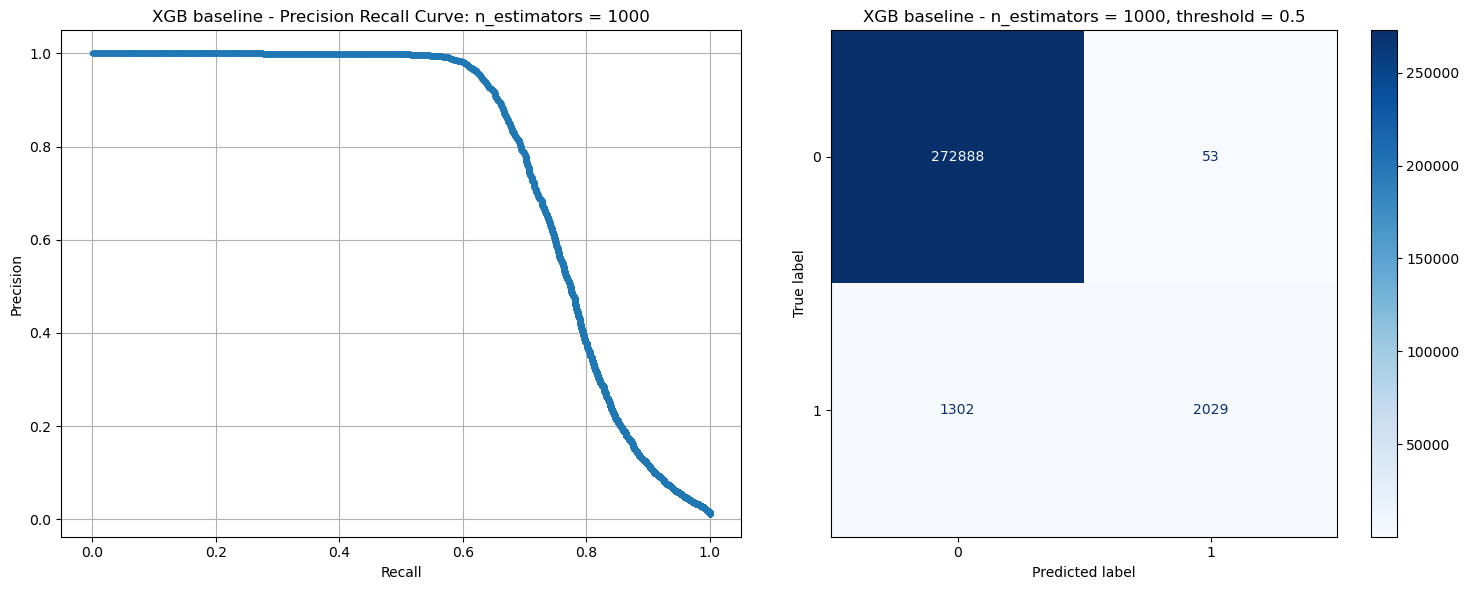

In [22]:
# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_xgboost_baseline)

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_model_baseline.classes_)

# Plot Precision Recall Curve and Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Precision-Recall Curve
ax[0].plot(recall, precision, marker='.')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('XGB baseline - Precision Recall Curve: n_estimators = 1000')
ax[0].grid()

# Plot Confusion Matrix
disp.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=True)
ax[1].set_title('XGB baseline - n_estimators = 1000, threshold = 0.5')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

This is about what I expected from preprocessing. Pretty good out of the boxt performance. 

## <a id='toc7_2_'></a>[Random Forest Baseline](#toc0_)

In [23]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=1000,  # 1000 estimators to match XGBoost above
                             max_depth=None,    # Maximum depth of each tree
                             min_samples_split=2,  
                             min_samples_leaf=1,   
                             random_state=42)  # Seed for random number generator

# Generate and save scores from cross validation
RF_cross_eval_results = strat_kfold_cross_val_classifier_eval(rf_model, X_train, y_train, print_results = True )

Accuracy mean: 0.9930313115320677
Precision mean: 0.9987583717763865
Recall mean: 0.42250145079413376
F1 mean: 0.5937673240316566
F05 mean: 0.7846460124821087
F2 mean: 0.4776025938999807
MCC mean: 0.6472873397063201


In [24]:
# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_model = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

In [25]:
# Calcualte results on test set
rf_test_set_results = create_classifier_scores_object(y_test,y_pred_rf_model, print_results=True)

Accuracy: 0.9936077488851567
Precision: 0.9980903882877148
Recall: 0.4707295106574602
F1: 0.6397388820889433
F05: 0.8153926157046282
F2: 0.5263511245384357
Matthews Corr Coef: 0.6832266178715434


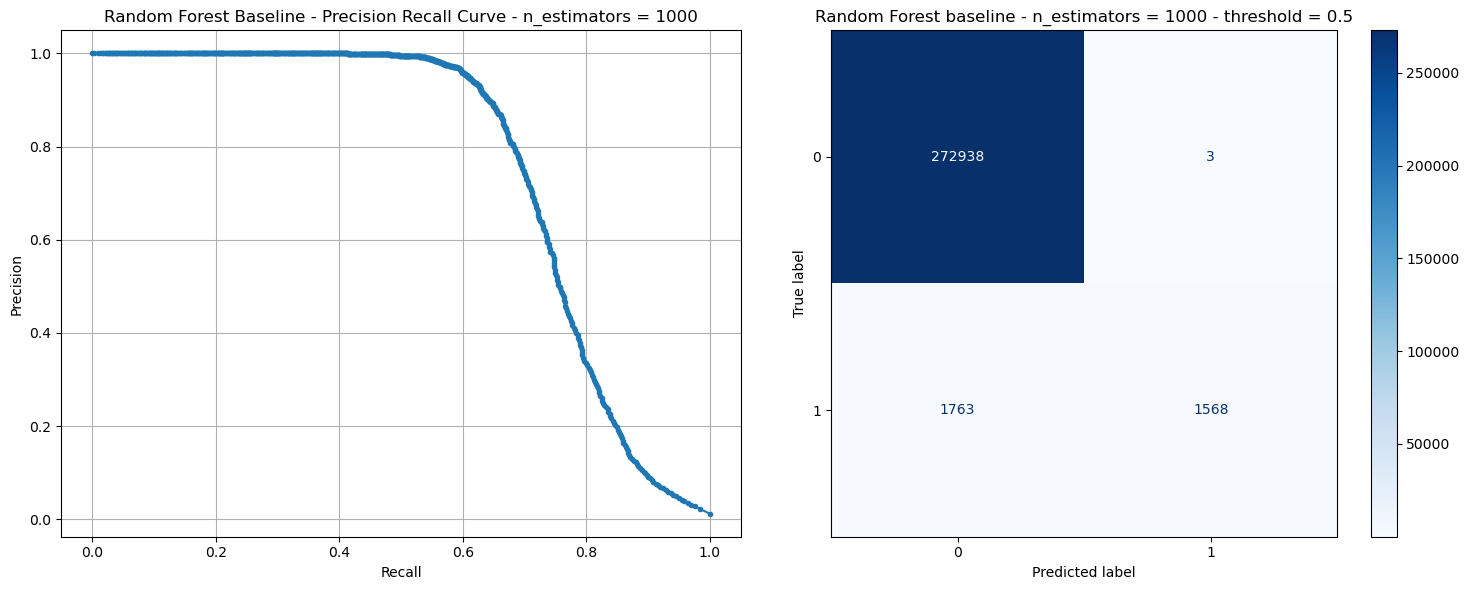

In [26]:
# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_rf)

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

# Plot Precision Recall Curve and Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Precision-Recall Curve
ax[0].plot(recall, precision, marker='.')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Random Forest Baseline - Precision Recall Curve - n_estimators = 1000')
ax[0].grid()

# Plot Confusion Matrix
disp.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=True)
ax[1].set_title('Random Forest baseline - n_estimators = 1000 - threshold = 0.5')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

Also decent results for an out of the box model. The tree based models, even ones without boosting like RF, see to be 
a good fit for this data. 

## <a id='toc7_3_'></a>[Balanced Random Forest Baseline](#toc0_)

The balanced RF model is designed to address imbalanced data sets in a more systematic way than the 
standard RF model.

In [27]:
balanced_rf_model = BalancedRandomForestClassifier(n_estimators = 1000,
    sampling_strategy="auto", 
    replacement=True, 
    max_depth=None,
    bootstrap=False, 
    random_state=42)

# Generate and save scores from cross validation
Balanced_rf_cross_eval_results = strat_kfold_cross_val_classifier_eval(balanced_rf_model, X_train, y_train, print_results = True )


Accuracy mean: 0.8749373345465175
Precision mean: 0.08055026336440788
Recall mean: 0.8999476868989064
F1 mean: 0.14786509836792858
F05 mean: 0.09848399225090204
F2 mean: 0.2965687467738828
MCC mean: 0.24761295866417865


In [28]:
# Train the model
balanced_rf_model.fit(X_train, y_train)

# Make predictions
y_pred_balanced_rf_model = balanced_rf_model.predict(X_test)
y_pred_prob_balanced_rf= balanced_rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

In [29]:
Balanced_rf_test_set_results = create_classifier_scores_object(y_test,y_pred_balanced_rf_model, print_results=True)

Accuracy: 0.8821994266519951
Precision: 0.08542884713628882
Recall: 0.903632542779946
F1: 0.15610009075586673
F05: 0.10432046136677134
F2: 0.3099386300918489
Matthews Corr Coef: 0.25702956581776304


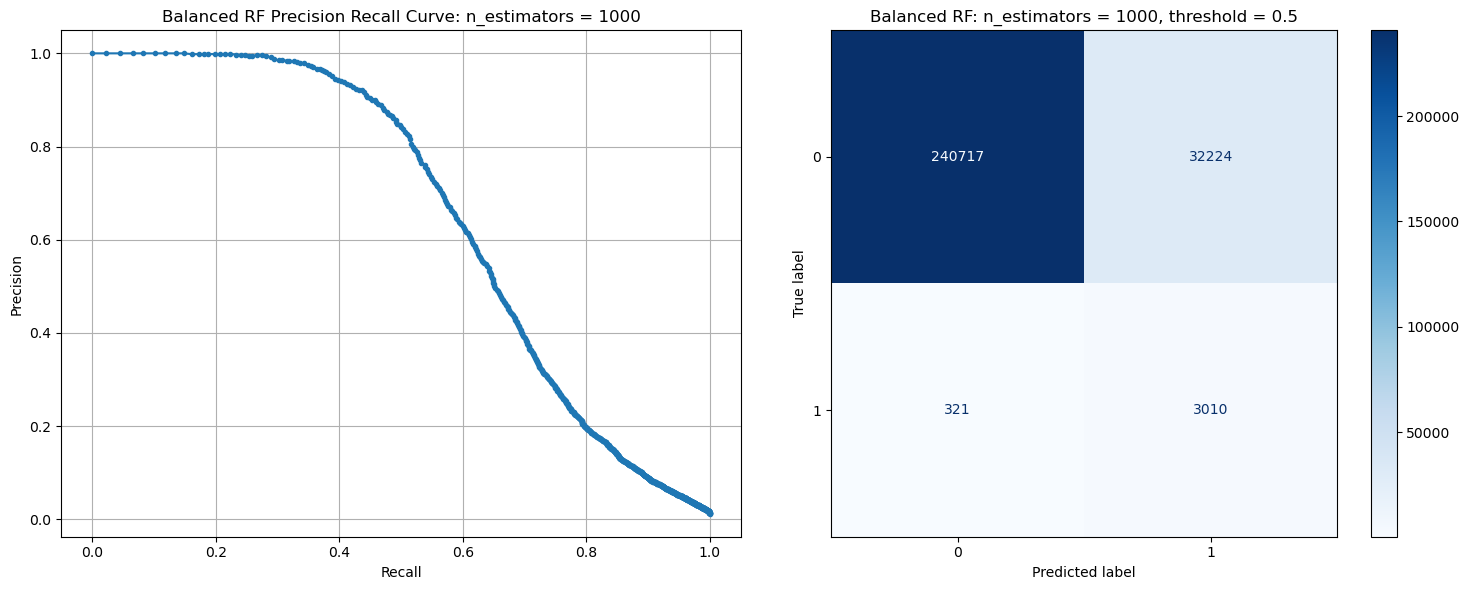

In [30]:
# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_balanced_rf)

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_balanced_rf_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=balanced_rf_model.classes_)

# Plot Precision Recall Curve and Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Precision-Recall Curve
ax[0].plot(recall, precision, marker='.')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Balanced RF Precision Recall Curve: n_estimators = 1000')
ax[0].grid()

# Plot Confusion Matrix
disp.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=True)
ax[1].set_title('Balanced RF: n_estimators = 1000, threshold = 0.5')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

The precision recall curve isn't quite as good at the other forest based models. The balanced RF model does show a significant difference in the 
confusion matrix. It's creating a lot more false positives than the other two approaches. 

## <a id='toc7_4_'></a>[SVM Approaches](#toc0_)

Using SVM here should provide a different modeling approach. One based on distance rather than trees. 

### <a id='toc7_4_1_'></a>[Scale data for use in SVM](#toc0_)

In [31]:
#Using Robust scaler here because there are lots of ourliers in the data. 
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## <a id='toc7_5_'></a>[Binary SVM Baseline](#toc0_)

This will be the standard out of the box SVM model. Built to find the decision boundary between two clases. 

In [32]:

# Initialize the SVC model
svm_model = SVC(kernel='rbf',        # Type of kernel (linear, poly, rbf, sigmoid)
            C=1.0,              # Regularization parameter
            gamma='scale',      # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'      
            random_state=42)    

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)
#y_pred_prob_svm = svm_model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

In [33]:
#Cross validation requires an absurd runtime. I'll just evaluate the models baseline performance on the test set here - just to get an idea of the performance.
SVM_results = create_classifier_scores_object(y_test, y_pred_svm, print_results = True)

Accuracy: 0.9890035906642729
Precision: 0.93993993993994
Recall: 0.09396577604323027
F1: 0.1708515283842795
F05: 0.3356208449496033
F2: 0.11459324888335652
Matthews Corr Coef: 0.2953411415542665


Displaying only the confusion matrix here. Getting the probabilities for the precision recall curve from the SVM model
is very compute intensive and not needed for this first evaluation of performance given the other metrics on hand. 

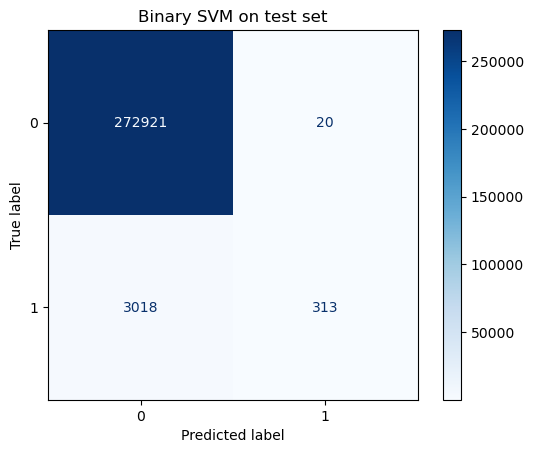

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Binary SVM on test set')
plt.show()

Initial results are much worse than the forest based approached. There are a lot of false negatives. Tuning could improve this certainly, but 
the potential of this model doesn't seem nearly as good based on the out of the box results. 

## <a id='toc7_6_'></a>[Single Class SVM](#toc0_)

Single class SVM is more of an anomoly detection approach. I'm going to train is on the Sepsis cases only. 

In [35]:
# Define X_train set for single class SVM - Filter X_train to be only the positive class
X_train_positive_class = X_train[y_train == 1].copy()

In [36]:
single_class_svm_scaler = RobustScaler()
X_train_positive_class_scaled = single_class_svm_scaler.fit_transform(X_train_positive_class)
X_test_scaled_for_single_class_svm = single_class_svm_scaler.transform(X_test)

In [37]:
# Initialize the OneClassSVM model
svm_single_class_model = OneClassSVM(kernel='rbf',        # Kernel type (linear, poly, rbf, sigmoid)
                    nu=0.5,              # An upper bound on the fraction of margin errors and a lower bound of the fraction of support vectors
                    gamma='scale'      # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
                    )     

# Fit the model with the training data (assuming X_train contains only the normal class)
svm_single_class_model.fit(X_train_positive_class_scaled)

# Predict on the test data
y_pred_single_class_svm = svm_single_class_model.predict(X_test_scaled_for_single_class_svm)

# Convert the predictions: 1 for normal, -1 for outlier
y_pred_normal_single_class_svm = np.where(y_pred_single_class_svm == 1, 1, 0)
#y_true_normal = np.where(y_test == 1, 1, 0)


In [38]:
SVM_single_class_results = create_classifier_scores_object(y_test, y_pred_normal_single_class_svm, print_results = True)

Accuracy: 0.8103825215729427
Precision: 0.03226606151909838
Recall: 0.5079555688982288
F1: 0.06067778375470683
F05: 0.03970209351110111
F2: 0.12864376625153962
Matthews Corr Coef: 0.0896246246319661


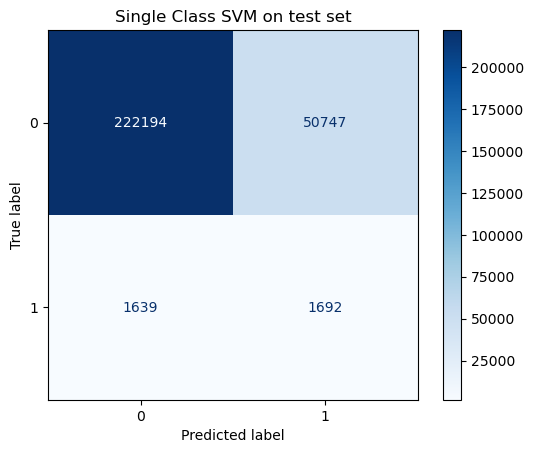

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_normal_single_class_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Single Class SVM on test set')
plt.show()

Interesting results. The binary SVM created false negatives. The single class SVM is going in the other direction. False positives here are really high.

## <a id='toc7_7_'></a>[Logisitic Regression](#toc0_)

The basic classification model. No reason not to try it. 

In [40]:
# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)

# Generate and save scores from cross validation
Log_reg_cross_eval_results = strat_kfold_cross_val_classifier_eval(log_reg_model, X_train_scaled, y_train, print_results = True )


Accuracy mean: 0.98805794299595
Precision mean: 0.5480010290685347
Recall mean: 0.05434187470772837
F1 mean: 0.09885986855540632
F05 mean: 0.19445191212939722
F2 mean: 0.06628048858694849
MCC mean: 0.16984896443383518


In [41]:
# Train the model
log_reg_model.fit(X_train_scaled, y_train)

y_pred_log_reg_model = log_reg_model.predict(X_test_scaled)
y_pred_prob_log_reg_model = log_reg_model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

X has feature names, but LogisticRegression was fitted without feature names


In [42]:
log_reg_test_set_results = create_classifier_scores_object(y_test,y_pred_log_reg_model, print_results=True )

Accuracy: 0.9880081948224938
Precision: 0.5277777777777778
Recall: 0.05133593515460823
F1: 0.09357045143638851
F05: 0.18478495785606225
F2: 0.06264654161781946
Matthews Corr Coef: 0.16191560610170946


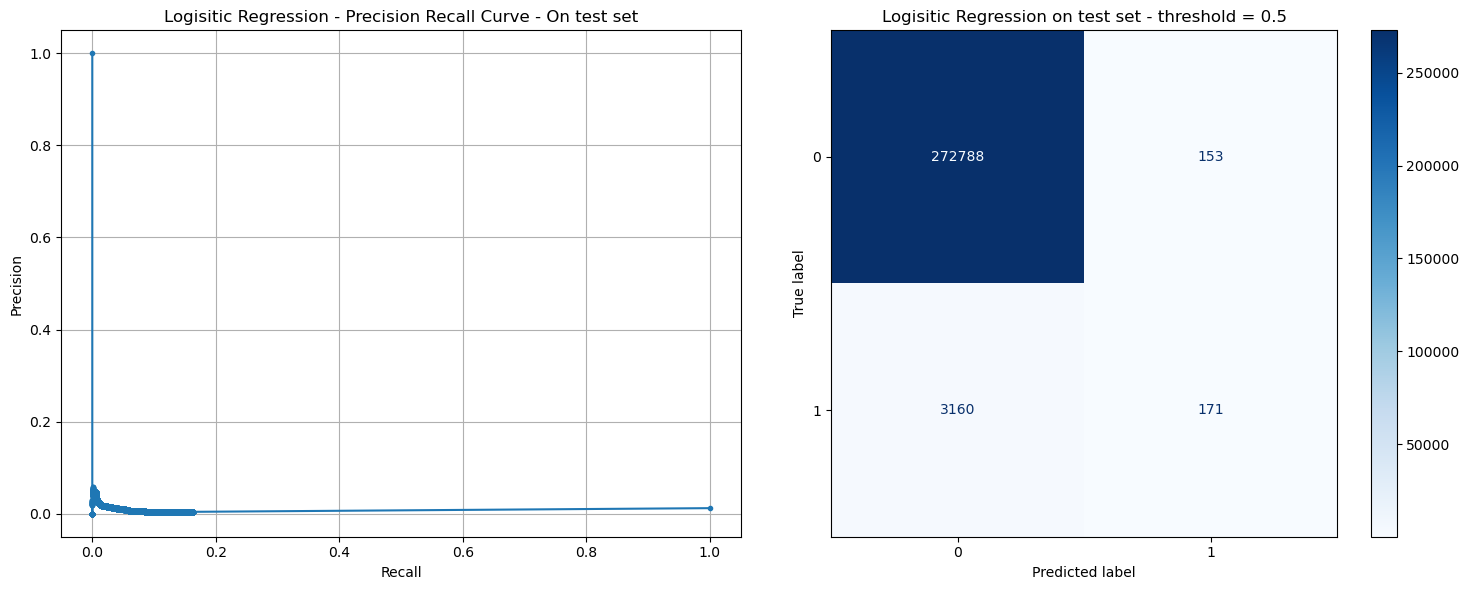

In [43]:
# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_log_reg_model)

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log_reg_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=balanced_rf_model.classes_)

# Plot Precision Recall Curve and Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Precision-Recall Curve
ax[0].plot(recall, precision, marker='.')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Logisitic Regression - Precision Recall Curve - On test set')
ax[0].grid()

# Plot Confusion Matrix
disp.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=True)
ax[1].set_title('Logisitic Regression on test set - threshold = 0.5')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

Worst performance yet. This does not seem to be a model that's worth looking at any further. 

# <a id='toc8_'></a>[Compare Initial Results](#toc0_)

In [44]:
#Define models and gather evalautions from each

results_list = [XGBoost_baseline_cross_eval_results,RF_cross_eval_results,Balanced_rf_cross_eval_results,\
                SVM_results,SVM_single_class_results,Log_reg_cross_eval_results]

model_list_baseline_results = ['XGB - CV', 'RF - CV', 'Balanced RF', 'Binary SVM - TS', 'One Class SVM - TS','Log Reg - CV']


#Add scores to lists for visual comparison
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
f05_scores = []
f2_scores = []
mcc_scores = []

for results in results_list:
      if results != SVM_results and results != SVM_single_class_results:
            accuracy_scores.append(round(results["test_accuracy"].mean(),3))
            precision_scores.append(round(results["test_precision"].mean(),3))
            recall_scores.append(round(results["test_recall"].mean(),3))
            f1_scores.append(round(results["test_f1"].mean(),3))
            f05_scores.append(round(results["test_f05"].mean(),3))
            f2_scores.append(round(results["test_f2"].mean(),3))
            mcc_scores.append(round(results["test_mcc"].mean(),3))
      else:
            accuracy_scores.append(round(results.accuracy,3))
            precision_scores.append(round(results.precision,3))
            recall_scores.append(round(results.recall,3))
            f1_scores.append(round(results.f1,3))
            f05_scores.append(round(results.f05,3))
            f2_scores.append(round(results.f2,3))
            mcc_scores.append(round(results.mcc,3))

#Create dict of scores to make table for comparison
scores_dict = {}

scores_dict['Accuracy'] = accuracy_scores
scores_dict['Precision'] = precision_scores
scores_dict['Recall'] = recall_scores
scores_dict['F1'] = f1_scores
scores_dict['F0.5'] = f05_scores
scores_dict['F2'] = f2_scores
scores_dict['Matthews Coef.'] = mcc_scores

scores_df = pd.DataFrame(scores_dict, index= model_list_baseline_results)

## <a id='toc8_1_'></a>[Precision And Recall](#toc0_)

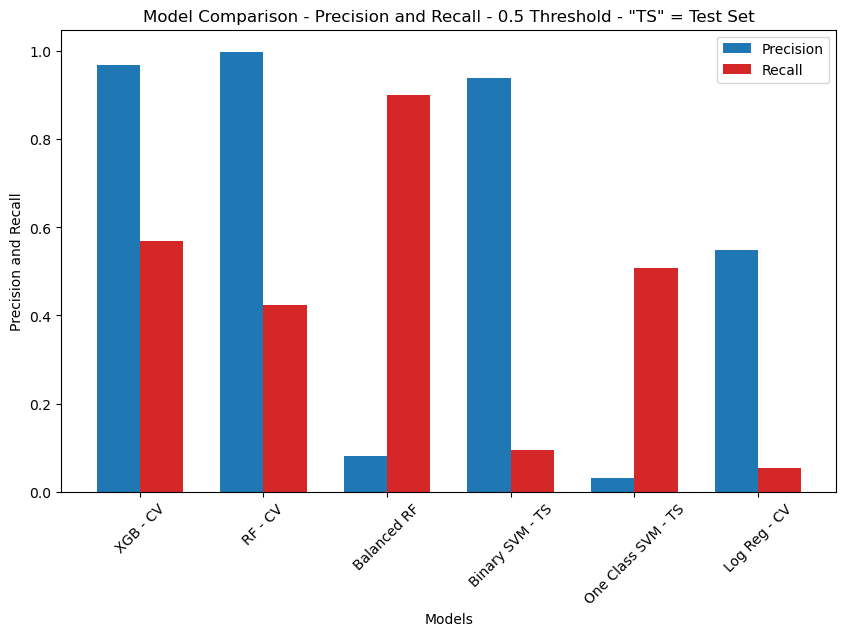

In [45]:
# Bar chart - side by side - single chart

# Set the width of the bars and positions
width = 0.35  # Width of the bars
x = np.arange(len(model_list_baseline_results))  # X positions for the categories

# Adjust the figure size
fig, ax = plt.subplots(figsize=(10, 6))  #(width, height)

# Plot two sets of bars
bar1 = ax.bar(x - width/2, precision_scores, width, color = 'Tab:blue' , label='Precision')
bar2 = ax.bar(x + width/2, recall_scores, width,color = 'Tab:red' ,label='Recall')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Precision and Recall')
ax.set_title('Model Comparison - Precision and Recall - 0.5 Threshold - "TS" = Test Set')
ax.set_xticks(x)
ax.set_xticklabels(model_list_baseline_results, rotation = 45)
ax.legend()

# Show the plot
plt.show()

XBG and RF are the only two models that are showing any sort of balance in Precision and Recall out of the box.
All the other models are massivley skewed in one direction or the other. 

## <a id='toc8_2_'></a>[F1, F2 and MCC](#toc0_)

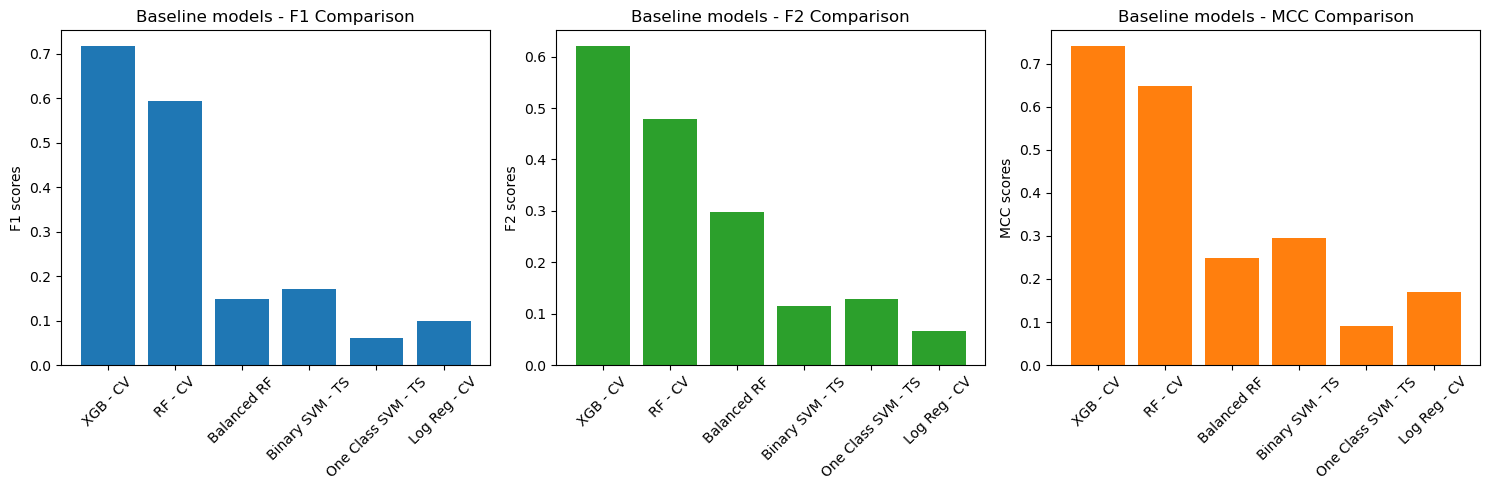

[0.74, 0.647, 0.248, 0.295, 0.09, 0.17]

In [46]:
# Create a figure with three subplots in a horizontal row
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # 3 subplots, in one row

# First bar chart - F1
axs[0].bar(model_list_baseline_results, scores_dict['F1'], color='Tab:blue')
axs[0].set_ylabel('F1 scores')
axs[0].set_title('Baseline models - F1 Comparison')
axs[0].set_xticks(range(len(model_list_baseline_results)))
axs[0].set_xticklabels(model_list_baseline_results, rotation=45)

# Second bar chart - F2
axs[1].bar(model_list_baseline_results, scores_dict['F2'], color='Tab:green')
axs[1].set_ylabel('F2 scores')
axs[1].set_title('Baseline models - F2 Comparison')
axs[1].set_xticks(range(len(model_list_baseline_results)))
axs[1].set_xticklabels(model_list_baseline_results, rotation=45)

# Third bar chart - MCC
axs[2].bar(model_list_baseline_results, scores_dict['Matthews Coef.'], color='Tab:orange')
axs[2].set_ylabel('MCC scores')
axs[2].set_title('Baseline models - MCC Comparison')
axs[2].set_xticks(range(len(model_list_baseline_results)))
axs[2].set_xticklabels(model_list_baseline_results, rotation=45)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


scores_dict['F1'] = f1_scores
scores_dict['F0.5'] = f05_scores
scores_dict['F2'] = f2_scores
scores_dict['Matthews Coef.']

Very similar results here in terms of which models are performing best. The is no threshold adjustment here. These are the results for the 
default 0.5 Threshold.

## <a id='toc8_3_'></a>[Results Table](#toc0_)

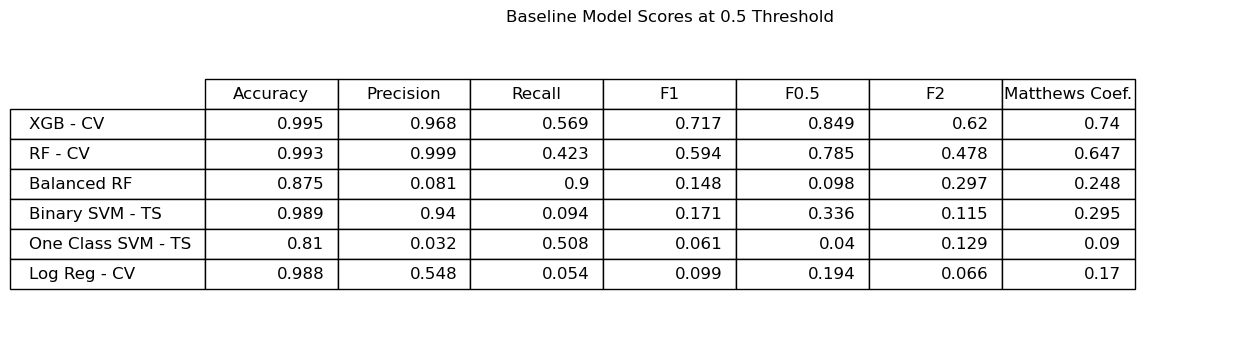

In [47]:
# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=scores_df.values, colLabels=scores_df.columns, rowLabels=scores_df.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Baseline Model Scores at 0.5 Threshold')
 
plt.show()

# <a id='toc9_'></a>[Explore Class Weights and Sampling Approaches](#toc0_)

I'll explore a few ways to address the class imbalance in the data below. 

One is class weights, which is a parameter of XGB and which I can potentially use in hyperparameter tuning. 

The other methods are all sampling methods on the data itself. I'll look at under-sampling, over-sampling with SMOTE,
and over-sampling with SMOTEENN below. 

These various approaches will be tried on the baseline XGBOOST model. 

## <a id='toc9_1_'></a>[Class Weights](#toc0_)

I'll try a range of class weight values below to get an idea of what effect manipulating this parameter might have during 
hyperparameter tuning. This will be the same baseline model as above but varying the class weights. 

In [48]:
ratio_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) # This is about 81.9

weights = [1,10,40,50,60,70,ratio_weight, 90, 100,500]

weight_trials_results = []
weight_trials_prob_results = []


for weight in weights:
    # Create an XGBoost model
    xgboost_model_class_weights = xgb.XGBClassifier(
        n_estimators = 1000,           # Large number of estimators
        objective='binary:logistic',  # For binary classification
        eval_metric='logloss',        # Evaluation metric
        use_label_encoder=False,       # Avoid deprecation warnings
        scale_pos_weight=(weight),      #Set class weights       
        random_state=42
    )
    # Train the model
    xgboost_model_class_weights.fit(X_train, y_train)

    # Make predictions
    y_pred_xgboost = xgboost_model_class_weights.predict(X_test)
    y_pred_prob_xgboost_class_weights = xgboost_model_class_weights.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

    result = create_classifier_scores_object(y_test,y_pred_xgboost)
    
    weight_trials_results.append(result)
    weight_trials_prob_results.append(y_pred_prob_xgboost_class_weights)

   

In [49]:
visual_dict_weights_trials = prep_classifer_score_obj_for_visuals(weight_trials_results,round_level = 3,units = weights)

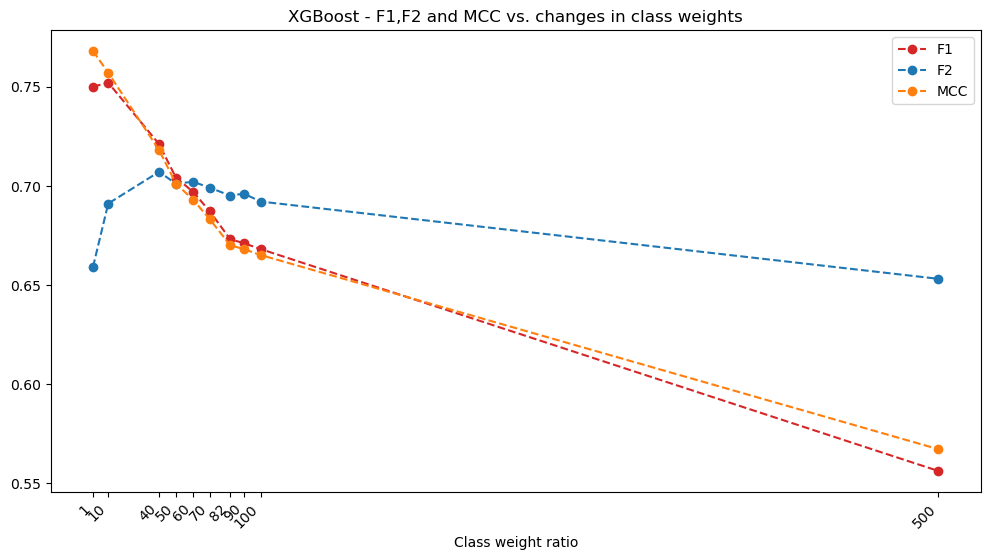

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(weights,visual_dict_weights_trials['F1'], marker = 'o',color='tab:red' ,linestyle = '--', label = 'F1')
plt.plot(weights,visual_dict_weights_trials['F2'], marker = 'o',color = 'tab:blue' ,linestyle = '--',  label = 'F2')
plt.plot(weights,visual_dict_weights_trials['Matthews Coef.'], marker = 'o',color = 'tab:orange' ,linestyle = '--',  label = 'MCC')

plt.xticks(visual_dict_weights_trials['Units'],rotation=45, ha='right' )
plt.xlabel('Class weight ratio')
#plt.ylabel('Accuracy Score')

#plt.axvline(x=40, color='r', linestyle='--', label='Threshold = 40')


plt.title('XGBoost - F1,F2 and MCC vs. changes in class weights')
plt.legend()

plt.show()

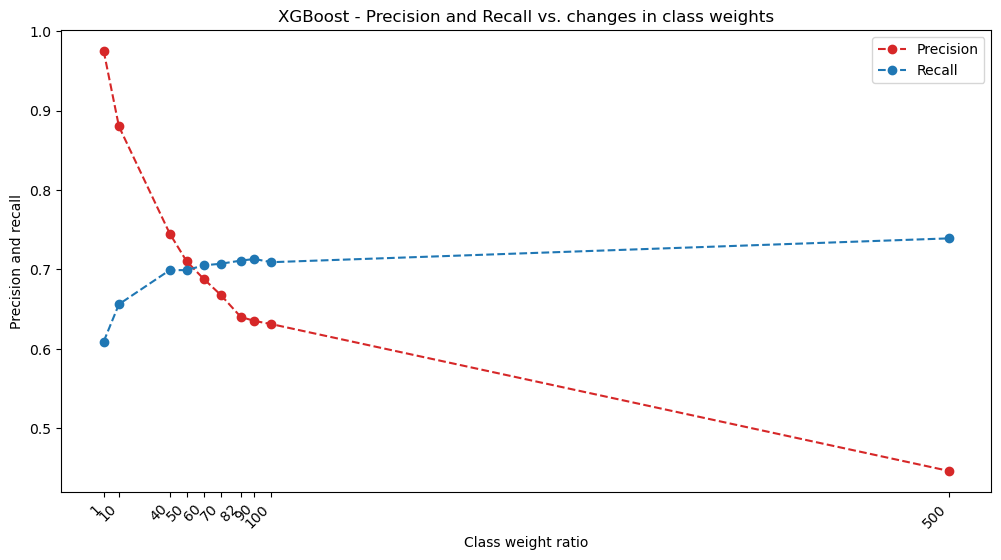

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(weights,visual_dict_weights_trials['Precision'], marker = 'o',color='tab:red' ,linestyle = '--', label = 'Precision')
plt.plot(weights,visual_dict_weights_trials['Recall'], marker = 'o',color = 'tab:blue' ,linestyle = '--',  label = 'Recall')


plt.xticks(visual_dict_weights_trials['Units'],rotation=45, ha='right' )
plt.xlabel('Class weight ratio')
plt.ylabel('Precision and recall')


#plt.axvline(x=40, color='r', linestyle='--', label='Threshold = 40')

plt.title('XGBoost - Precision and Recall vs. changes in class weights')
plt.legend()

plt.show()

Manipulating the class weights does seem to have a significant effect based on the above. It seems like including 
class weights as a hyperparameter could be beneficial in terms of finding a balance between precision and recall
in the tuned model.

## <a id='toc9_2_'></a>[Under sampling](#toc0_)

Under sampling didn't reall work all that well in the preprocessing notebook. I'll run a model with it here to compare the results with an over sampling approach. 

In [52]:
# Initialize the RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_train_under_sampled, y_train_under_sampled = under_sampler.fit_resample(X_train, y_train)

# Create an XGBoost model
xgboost_model_under_sample = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)

In [53]:
check_binary_labels_ratio(y_train_under_sampled)

Class counts:
 Class
0    13323
1    13323
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 1.0

Class percentages:
 Class
0    50.0
1    50.0
Name: count, dtype: float64


Unsuprisingly, a drastic reduction in the number of samples to learn from. 

In [54]:
# Generate and save scores from cross validation
XGBoost_cross_eval_results_under_sample = strat_kfold_cross_val_classifier_eval(xgboost_model_under_sample, X_train_under_sampled, y_train_under_sampled, print_results = True )

Accuracy mean: 0.8838475726818847
Precision mean: 0.8728550394118579
Recall mean: 0.8985974342071902
F1 mean: 0.8855240479270602
F05 mean: 0.8778754049175335
F2 mean: 0.8933182394253398
MCC mean: 0.7680587169994132


In [55]:
xgboost_model_under_sample.fit(X_train_under_sampled, y_train_under_sampled)
xgboost_model_under_sample_y_pred = xgboost_model_under_sample.predict(X_test)

XGBoost_test_set_undersampling_results = create_classifier_scores_object(y_test,xgboost_model_under_sample_y_pred, print_results=True)

Accuracy: 0.881290901720044
Precision: 0.08491815287521483
Recall: 0.9048333833683578
F1: 0.15526478466927673
F05: 0.10371430734396399
F2: 0.30870393510457417
Matthews Corr Coef: 0.2563146941783731


These are good numbers, but they seem too good. I suspect the model is overfitting, or the undersampling was just good by chance. 
I know from the preprocessing notebook that repeating this process many times and taking the average drives up recall but makes precision very low. 
That being said, what about looking at the scores without averaging them. 

I'll run the model 20 times in this configuration and see how it does.

In [56]:
runs_num = []
cross_validation_accuracy = []
test_set_accuracy = []

cross_validation_precision = []
test_set_precision = []

cross_validation_recall = []
test_set_recall = []

cross_validation_f1 = []
test_set_f1 = []

cross_validation_f05= []
test_set_f05= []

cross_validation_f2 = []
test_set_f2 = []

cross_validation_mcc = []
test_set_mcc = []

for i in range(20):
    # Initialize the RandomUnderSampler
    under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

    # Fit and resample the training data
    X_train_under_sampled, y_train_under_sampled = under_sampler.fit_resample(X_train, y_train)

    # Create an XGBoost model
    xgboost_model_under_sample = xgb.XGBClassifier(
        n_estimators = 1000,           # Large number of estimators
        objective='binary:logistic',  # For binary classification
        eval_metric='logloss',        # Evaluation metric
        use_label_encoder=False,       # Avoid deprecation warnings
        random_state=42
    )

    xgboost_model_under_sample.fit(X_train_under_sampled, y_train_under_sampled)
    y_pred = xgboost_model_under_sample.predict(X_test)

    #Create scores for this run on the test set
    XGBoost_single_run_test_set_scores = create_classifier_scores_object(y_test,y_pred)

    #Run cross validation
    XGBoost_cross_eval_results_under_sample = strat_kfold_cross_val_classifier_eval(xgboost_model_under_sample, X_train_under_sampled, y_train_under_sampled)

    # Append Cross Validation results
    runs_num.append(i)
    cross_validation_accuracy.append(XGBoost_cross_eval_results_under_sample["test_accuracy"].mean())
    cross_validation_precision.append(XGBoost_cross_eval_results_under_sample["test_precision"].mean())
    cross_validation_recall.append(XGBoost_cross_eval_results_under_sample["test_recall"].mean())
    cross_validation_f1.append(XGBoost_cross_eval_results_under_sample["test_f1"].mean())
    cross_validation_f05.append(XGBoost_cross_eval_results_under_sample["test_f05"].mean())
    cross_validation_f2.append(XGBoost_cross_eval_results_under_sample["test_f2"].mean())
    cross_validation_mcc.append(XGBoost_cross_eval_results_under_sample["test_mcc"].mean())

    #Append Test_set results
    test_set_accuracy.append(XGBoost_single_run_test_set_scores.accuracy)
    test_set_precision.append(XGBoost_single_run_test_set_scores.precision)
    test_set_recall.append(XGBoost_single_run_test_set_scores.recall)
    test_set_f1.append(XGBoost_single_run_test_set_scores.f1)
    test_set_f05.append(XGBoost_single_run_test_set_scores.f05)
    test_set_f2.append(XGBoost_single_run_test_set_scores.f2)
    test_set_mcc.append(XGBoost_single_run_test_set_scores.mcc)

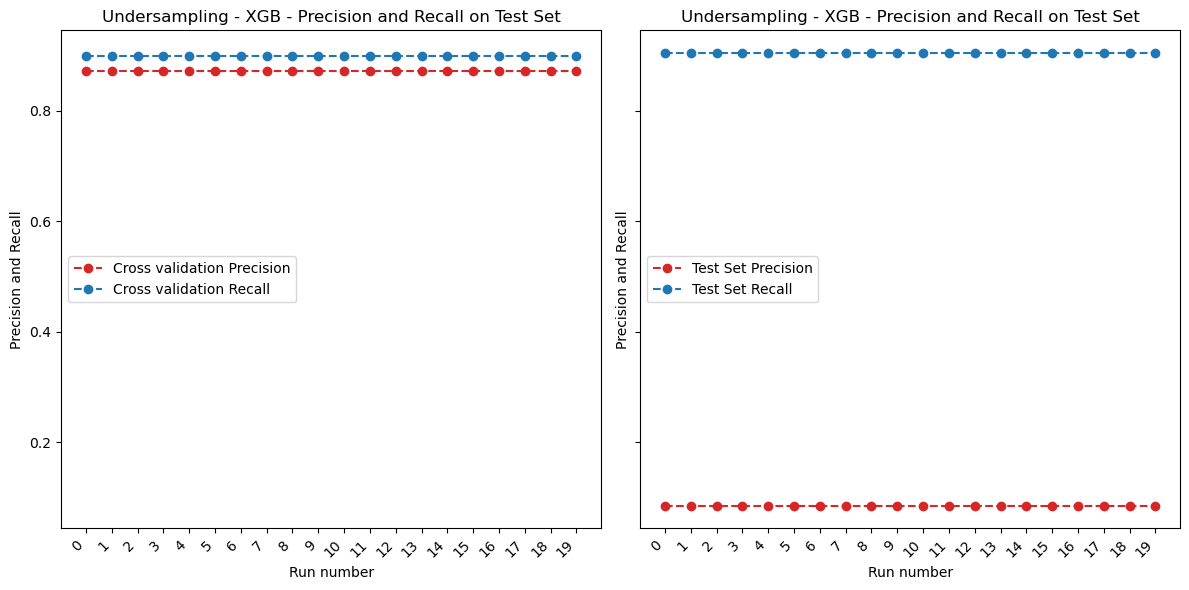

In [57]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# First subplot for cross-validation precision and recall
ax1.plot(runs_num, cross_validation_precision, marker='o', color='tab:red', linestyle='--', label='Cross validation Precision')
ax1.plot(runs_num, cross_validation_recall, marker='o', color='tab:blue', linestyle='--', label='Cross validation Recall')
ax1.set_xticks(runs_num)
ax1.set_xticklabels(runs_num, rotation=45, ha='right')
ax1.set_xlabel('Run number')
ax1.set_ylabel('Precision and Recall')
ax1.set_title('Undersampling - XGB - Precision and Recall on Test Set')
ax1.legend(loc = 'center left')

# Second subplot for test set precision and recall
ax2.plot(runs_num, test_set_precision, marker='o', color='tab:red', linestyle='--', label='Test Set Precision')
ax2.plot(runs_num, test_set_recall, marker='o', color='tab:blue', linestyle='--', label='Test Set Recall')
ax2.set_xticks(runs_num)
ax2.set_xticklabels(runs_num, rotation=45, ha='right')
ax2.set_xlabel('Run number')
ax2.set_ylabel('Precision and Recall')
ax2.set_title('Undersampling - XGB - Precision and Recall on Test Set')
ax2.legend(loc = 'center left')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Pretty big difference when the model tries to look at unseen data - Recall stays high, precision plummets. The model does not generalize well to the test set. 
Classic overfit. 

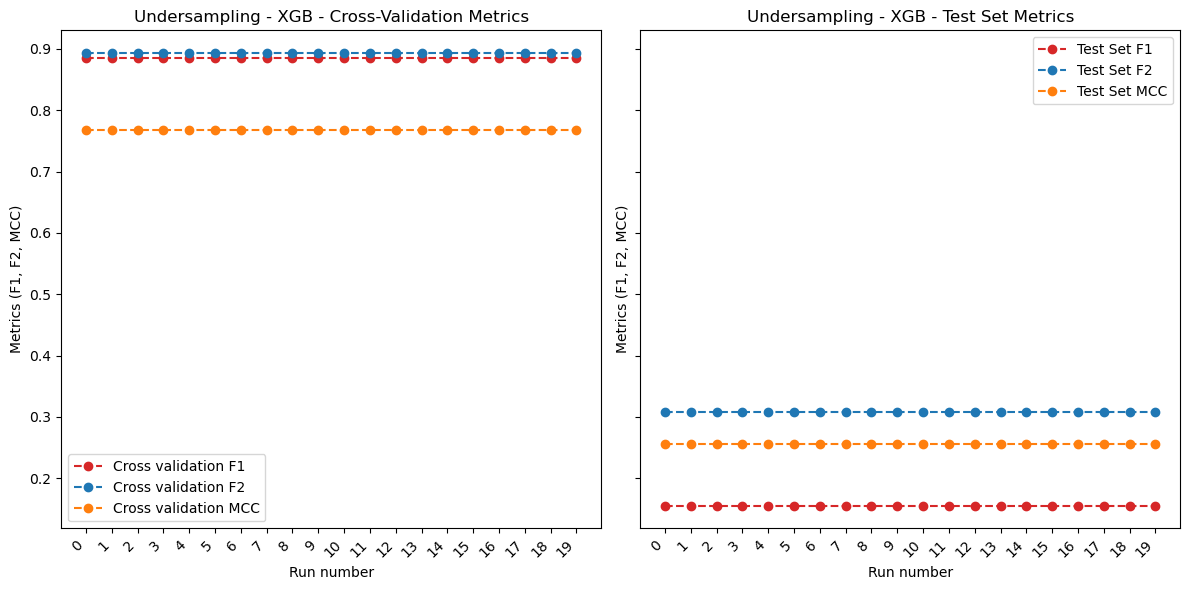

In [58]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot for cross-validation metrics (F1, F2, MCC)
ax1.plot(runs_num, cross_validation_f1, marker='o', color='tab:red', linestyle='--', label='Cross validation F1')
ax1.plot(runs_num, cross_validation_f2, marker='o', color='tab:blue', linestyle='--', label='Cross validation F2')
ax1.plot(runs_num, cross_validation_mcc, marker='o', color='tab:orange', linestyle='--', label='Cross validation MCC')
ax1.set_xticks(runs_num)
ax1.set_xticklabels(runs_num, rotation=45, ha='right')
ax1.set_xlabel('Run number')
ax1.set_ylabel('Metrics (F1, F2, MCC)')
ax1.set_title('Undersampling - XGB - Cross-Validation Metrics')
ax1.legend()

# Second subplot for test set metrics (F1, F2, MCC)
ax2.plot(runs_num, test_set_f1, marker='o', color='tab:red', linestyle='--', label='Test Set F1')
ax2.plot(runs_num, test_set_f2, marker='o', color='tab:blue', linestyle='--', label='Test Set F2')
ax2.plot(runs_num, test_set_mcc, marker='o', color='tab:orange', linestyle='--', label='Test Set MCC')
ax2.set_xticks(runs_num)
ax2.set_xticklabels(runs_num, rotation=45, ha='right')
ax2.set_xlabel('Run number')
ax2.set_ylabel('Metrics (F1, F2, MCC)')
ax2.set_title('Undersampling - XGB - Test Set Metrics')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Also poor generalizaton. Looks like the model overfits when using the undersampled data alone. 

## <a id='toc9_3_'></a>[Over sampling with SMOTE](#toc0_)

In [59]:
# Initialize SMOTE oversampler
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, y_train)

# Create an XGBoost model
xgboost_model_over_sample = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)


In [60]:
check_binary_labels_ratio(y_train_over_sampled)

Class counts:
 Class
0    1091763
1    1091763
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 1.0

Class percentages:
 Class
0    50.0
1    50.0
Name: count, dtype: float64


Definitely more data for the model with the oversampling approach, but is the extra data making extra signal, or just more noise. 

In [61]:
# Generate and save scores from cross validation
XGBoost_oversample_cross_eval_results = strat_kfold_cross_val_classifier_eval(xgboost_model_over_sample, X_train_over_sampled, y_train_over_sampled, print_results = True )

Accuracy mean: 0.9912128364767577
Precision mean: 0.9938714023399594
Recall mean: 0.988521318283144
F1 mean: 0.991189122606768
F05 mean: 0.9927967458470899
F2 mean: 0.989586710489298
MCC mean: 0.9824399430881872


These are also suspiciously good results. Let's see how this model fares with the test set. The above was just cross validaton. 

In [62]:
xgboost_model_over_sample.fit(X_train_over_sampled, y_train_over_sampled)
y_pred_over_sample_test_set = xgboost_model_over_sample.predict(X_test)

In [63]:
smote_oversample_test_set = create_classifier_scores_object(y_test, y_pred_over_sample_test_set, print_results=True)

Accuracy: 0.9896189262755545
Precision: 0.5645026469768738
Recall: 0.6082257580306214
F1: 0.5855491329479768
F05: 0.5727370385028553
F2: 0.5989475551351032
Matthews Corr Coef: 0.5807142085711368


Certainly a big drop across the board when the model looks at unseen data. Overfitting to the training set again. 

## <a id='toc9_4_'></a>[Over sampling with SMOTEENN](#toc0_)

SMOTEENN is a variation of SMOTE. It first performs the normal SMOTE oversampling and then applies Editied Nearest Neighbors
to remove "noisy" samples that don't match their nearest neighbors.

In [64]:
# Initialize SMOTEENN
smote_ENN = SMOTEENN(random_state=42)

# Fit and resample the training data
X_train_SMOTEENN_resampled, y_train_SMOTEENN_resampled = smote_ENN.fit_resample(X_train, y_train)

# Create an XGBoost model
xgboost_model_SMOTEENN = xgb.XGBClassifier(
    n_estimators = 1000,           # Large number of estimators
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,       # Avoid deprecation warnings
    random_state=42
)


In [65]:
check_binary_labels_ratio(y_train_SMOTEENN_resampled)

Class counts:
 Class
1    1061764
0     978609
Name: count, dtype: int64
Ratio of classes (class 1 to class 2): 1.0849726499551915

Class percentages:
 Class
1    52.03774
0    47.96226
Name: count, dtype: float64


Ratios look like they are being preserved in the resampling. 

In [66]:
XGBoost_SMOTEENN_cross_eval_results = strat_kfold_cross_val_classifier_eval(xgboost_model_SMOTEENN, X_train_SMOTEENN_resampled, y_train_SMOTEENN_resampled, print_results = True )

Accuracy mean: 0.9921034047088082
Precision mean: 0.993722074323693
Recall mean: 0.9910865317177239
F1 mean: 0.9924025488912868
F05 mean: 0.9931938422601867
F2 mean: 0.9916125184941282
MCC mean: 0.9841860870592491


Similar story here - the over-sampling is having a dramtic effect. But does it generalize? 

In [67]:
xgboost_model_SMOTEENN.fit(X_train_SMOTEENN_resampled, y_train_SMOTEENN_resampled)
y_pred_SMOTEENN_test_set = xgboost_model_SMOTEENN.predict(X_test)

In [68]:
smoteenn_test_set = create_classifier_scores_object(y_test, y_pred_SMOTEENN_test_set, print_results=True)

Accuracy: 0.9857423119244803
Precision: 0.4376282314320886
Recall: 0.6403482437706395
F1: 0.5199268738574041
F05: 0.4672098830332501
F2: 0.586053412462908
Matthews Corr Coef: 0.5225488684189198


Same thing as above, even with the SMOTEENN there is overfitting to the training set. 

## <a id='toc9_5_'></a>[Sampling Approaches Comparison](#toc0_)

In [69]:
results = [XGBoost_test_set_results,
    XGBoost_test_set_undersampling_results,
    smote_oversample_test_set,
    smoteenn_test_set]

model_list_sampling_approaches = ['XGB_no_sampling', 'XGB_under-sampling','XGB_over-sampling','XGB_SMOTEENN']

In [70]:
sampling_approach_comparison = prep_classifer_score_obj_for_visuals(results,round_level = 3,units = model_list_sampling_approaches)

In [71]:
sampling_approaches_comparison_df = pd.DataFrame(sampling_approach_comparison, index = sampling_approach_comparison['Units'])
sampling_approaches_comparison_df.drop(columns='Units', inplace=True)


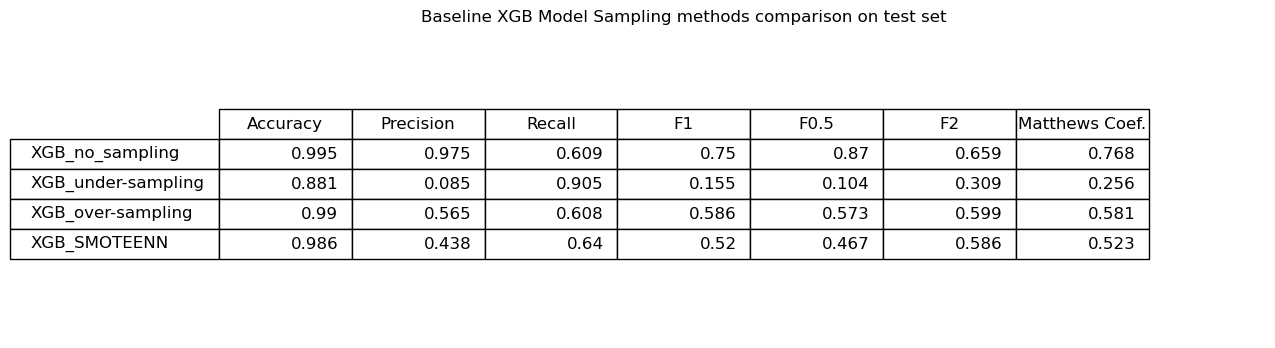

In [72]:
# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=sampling_approaches_comparison_df.values, colLabels=sampling_approaches_comparison_df.columns, rowLabels=sampling_approaches_comparison_df.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Baseline XGB Model Sampling methods comparison on test set')
 
plt.show()

Given the overfitting, it seemed best to compare the sampling approaches based on performance on the test set. 
Accuracy is high for all all approaches, but by far the best results come from just using the data as it is. 

I'm curious if hyperparameter tuning will improve performance with some of the sampling approaches. I'll try it below on the untouched data,
as well as the data sampled using SMOTE and SMOTEENN.

# <a id='toc10_'></a>[Hyperparameter Tuning](#toc0_)

In [73]:
# Define the search space
search_space = [
    Integer(100,1500, name='n_estimators'),   # Range for n_estimators
    Integer(0, 12, name='max_depth'), 
    Integer(1,50, name = 'scale_pos_weight'), # default is 1, range = inf
    Real(0.1,0.9, name = 'eta'), #eta default = 0.3, range [0,1]
    Real(0,10, name = 'gamma'), #default = 0, range = 0-inf
    Real(0,10, name = 'min_child_weight'), #min_child_weight [default=1] range: [0,∞]
    Real(0,1, name = 'subsample'), #subsample [default=1] range: (0,1]
    Real(1,10, name = 'lambda'), #default = 1, range = inf
    Real(0,10, name = 'alpha') #default = 0, range = inf
    #Real(50,500, name = 'early_stopping_rounds')
]

I'm defining 3 objective funcitons here for the multiple sampling approaches - The over-sampling is overfitting, but maybe 
some hyper-parameter tuning will control some of that tendency. 

In [74]:
# Define the objective function (maximize by negating the result) - For each model - search across the thresholds

#X_train, y_train
def objective_function_no_sampling(params):
    n_estimators = params[0]
    max_depth = params[1]
    scale_pos_weight = params[2]
    eta = params[3]
    gamma = params[4]
    min_child_weight = params[5]
    subsample = params[6]
    reg_lambda = params[7]
    alpha = params[8]

    # Initialize XGB model
    xgboost_model_no_sampling = xgb.XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            scale_pos_weight = scale_pos_weight,
            eta = eta,
            gamma = gamma,
            min_child_weight = min_child_weight,
            subsample = subsample,
            reg_lambda = reg_lambda,
            alpha = alpha,
            objective='binary:logistic',  
            eval_metric='logloss',        
            use_label_encoder=False,       # Avoid deprecation warnings
            random_state=42
            )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    f2_scorer = make_scorer(fbeta_score, beta = 2)
    f2 = cross_val_score(xgboost_model_no_sampling, X_train, y_train, cv=cv, scoring=f2_scorer).mean()

    # Negate the F1 score to maximize it
    return -f2


#X_train_over_sampled,y_train_over_sampled
def objective_function_SMOTE(params):
    n_estimators = params[0]
    max_depth = params[1]
    scale_pos_weight = params[2]
    eta = params[3]
    gamma = params[4]
    min_child_weight = params[5]
    subsample = params[6]
    reg_lambda = params[7]
    alpha = params[8]

    # Initialize XGB model
    xgboost_model_smote_sampling = xgb.XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            scale_pos_weight = scale_pos_weight,
            eta = eta,
            gamma = gamma,
            min_child_weight = min_child_weight,
            subsample = subsample,
            reg_lambda = reg_lambda,
            alpha = alpha,
            objective='binary:logistic',  
            eval_metric='logloss',        
            use_label_encoder=False,       # Avoid deprecation warnings
            random_state=42
            )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    f2_scorer = make_scorer(fbeta_score, beta = 2)
    f2 = cross_val_score(xgboost_model_smote_sampling, X_train_over_sampled, y_train_over_sampled, cv=cv, scoring=f2_scorer).mean()

    # Negate the F1 score to maximize it
    return -f2 


#X_train_SMOTEENN_resampled,y_train_SMOTEENN_resampled
def objective_function_SMOTEENN(params):
    n_estimators = params[0]
    max_depth = params[1]
    scale_pos_weight = params[2]
    eta = params[3]
    gamma = params[4]
    min_child_weight = params[5]
    subsample = params[6]
    reg_lambda = params[7]
    alpha = params[8]

    # Initialize XGB model
    xgboost_model_smoteenn_sampling = xgb.XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            scale_pos_weight = scale_pos_weight,
            eta = eta,
            gamma = gamma,
            min_child_weight = min_child_weight,
            subsample = subsample,
            reg_lambda = reg_lambda,
            alpha = alpha,
            objective='binary:logistic',  
            eval_metric='logloss',        
            use_label_encoder=False,       # Avoid deprecation warnings
            random_state=42
            )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    f2_scorer = make_scorer(fbeta_score, beta = 2)
    f2 = cross_val_score(xgboost_model_smoteenn_sampling, X_train_SMOTEENN_resampled, y_train_SMOTEENN_resampled, cv=cv, scoring=f2_scorer).mean()

    # Negate the F1 score to maximize it
    return -f2 


objective_function_no_sampling


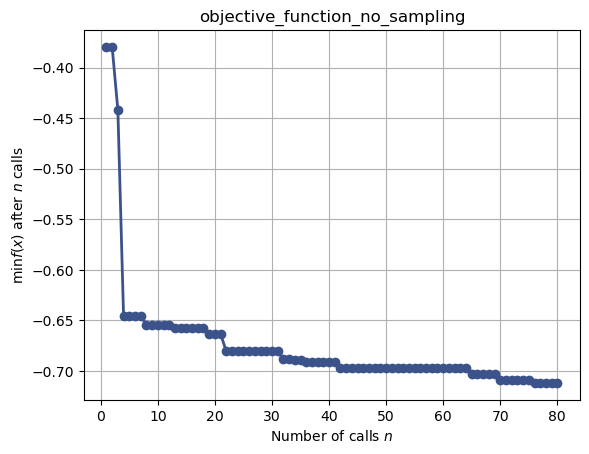

Best cross validated f2 score for this model :0.7118359913362706 

objective_function_SMOTE


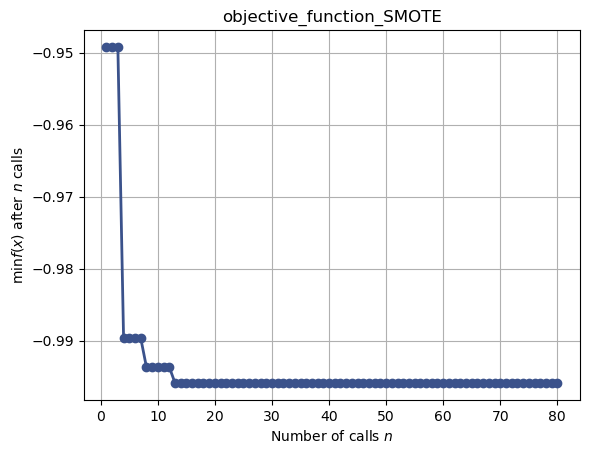

Best cross validated f2 score for this model :0.995865857530535 

objective_function_SMOTEENN


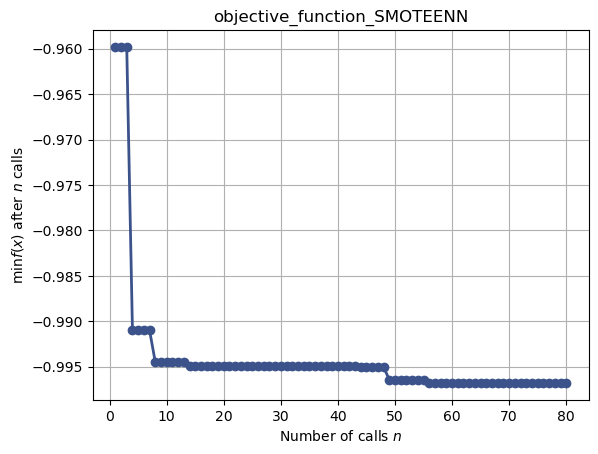

Best cross validated f2 score for this model :0.996790597755901 



In [75]:
objective_funcitons = [objective_function_no_sampling,objective_function_SMOTE,objective_function_SMOTEENN]

sampled_data_results = {}

for function in objective_funcitons:
    print(function.__name__)
    
    result = gp_minimize(
        function,  # The function to minimize
        search_space,        # The search space
        n_calls=80,          # Number of calls to evaluate the function - I picked 80 based on running the tuning a couple times and looking at how it converged.
        random_state=42 )


    plot_convergence(result)
    plt.title(function.__name__)
    plt.show()

    print(f'Best cross validated f2 score for this model :{-result.fun}','\n')

    best_params = result.x

    #calulate_test_set_performance
    XGB_model_best_params = xgb.XGBClassifier(
            n_estimators = best_params[0],
            max_depth = best_params[1],
            scale_pos_weight = best_params[2],
            eta = best_params[3],
            gamma = best_params[4],
            min_child_weight = best_params[5],
            subsample = best_params[6],
            reg_lambda = best_params[7],
            alpha = best_params[8],
            objective='binary:logistic',  
            eval_metric='logloss',        
            use_label_encoder=False,       # Avoid deprecation warnings
            random_state=42)


    if function.__name__ == 'objective_function_no_sampling':
        XGB_model_best_params.fit(X_train,y_train)
        y_pred = XGB_model_best_params.predict(X_test)

        test_set_scores = create_classifier_scores_object(y_test,y_pred)

    elif function.__name__== 'objective_function_SMOTE':
        XGB_model_best_params.fit(X_train_over_sampled, y_train_over_sampled)
        y_pred = XGB_model_best_params.predict(X_test)

        test_set_scores = create_classifier_scores_object(y_test,y_pred)
        
    elif function.__name__== 'objective_function_SMOTEENN':
        XGB_model_best_params.fit(X_train_SMOTEENN_resampled, y_train_SMOTEENN_resampled)
        y_pred = XGB_model_best_params.predict(X_test)

        test_set_scores = create_classifier_scores_object(y_test,y_pred)
    

    sampled_data_results[function.__name__] = {'params': result.x, 'cross_val_f2_score':-result.fun, 'test_set_f2':test_set_scores.f2, 'test_set_scores':test_set_scores}


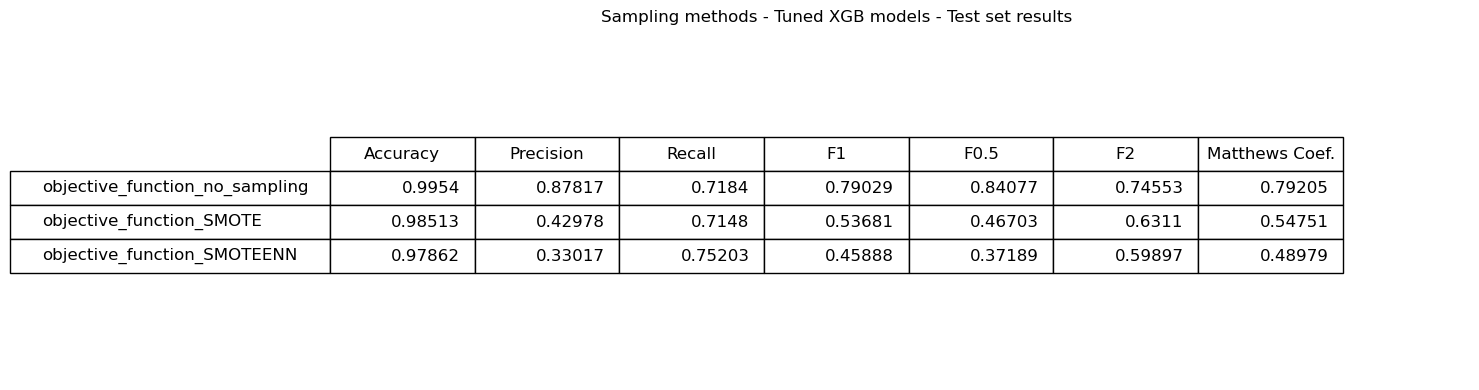

In [76]:
sampling_strategy_models = []
sampling_strategy_models_index_names = []

for key in sampled_data_results.keys():
    sampling_strategy_models_index_names.append(key)
    sampling_strategy_models.append(sampled_data_results[key]['test_set_scores'])


sampling_strategy_results = prep_classifer_score_obj_for_visuals(sampling_strategy_models,round_level = 5,units = None)

results_comparison_df = pd.DataFrame(sampling_strategy_results, index = sampling_strategy_models_index_names)

# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_comparison_df.values, colLabels=results_comparison_df.columns, rowLabels=results_comparison_df.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Sampling methods - Tuned XGB models - Test set results')

plt.tight_layout()
 
plt.show()


Recall is almost the same for all the models, but the other metrics are worse. Using the data as it is does seem to be the right approach. 
I'll use the parameters from that objective function for the final model.

In [77]:
#objective_funcitons = [objective_function_no_sampling,objective_function_SMOTE,objective_function_SMOTEENN]

best_objective_function = 'objective_function_no_sampling'

# Retrieve the best parameters and the maximized F2 score
best_params = sampled_data_results['objective_function_no_sampling']['params']
cv_score = sampled_data_results['objective_function_no_sampling']['cross_val_f2_score']
test_score = sampled_data_results['objective_function_no_sampling']['test_set_f2']

print(f"Best parameters: \n\
        n_estimators = {best_params[0]} \n\
        max_depth = {best_params[1]} \n\
        scale_pos_weight = {best_params[2]}\n\
        eta = {best_params[3]} \n\
        gamma = {best_params[4]} \n\
        min_child_weight = {best_params[5]} \n\
        subsample = {best_params[6]} \n\
        reg_lambda = {best_params[7]}\n\
        alpha = {best_params[8]} ")

print('\n',f"Best F2 score Cross Validation: {cv_score}")
print('\n',f"Best F2 score Test Set: {test_score}")

Best parameters: 
        n_estimators = 1500 
        max_depth = 11 
        scale_pos_weight = 50
        eta = 0.1 
        gamma = 0.0 
        min_child_weight = 10.0 
        subsample = 0.9249283573691198 
        reg_lambda = 1.332913648523872
        alpha = 10.0 

 Best F2 score Cross Validation: 0.7118359913362706

 Best F2 score Test Set: 0.7455293164683158


## <a id='toc10_1_'></a>[Instantiate model with best params and sampling method](#toc0_)

In [78]:
XGB_model_best_params = xgb.XGBClassifier(
            n_estimators = best_params[0],
            max_depth = best_params[1],
            scale_pos_weight = best_params[2],
            eta = best_params[3],
            gamma = best_params[4],
            min_child_weight = best_params[5],
            subsample = best_params[6],
            reg_lambda = best_params[7],
            alpha = best_params[8],
            objective='binary:logistic',  
            eval_metric='logloss',        
            use_label_encoder=False,       # Avoid deprecation warnings
            random_state=42)


## <a id='toc10_2_'></a>[Optimize threshold for best params](#toc0_)

This will be a function to optimize the threshold based on cross validation - not on the test set. 

In [79]:
def optimize_threshold_cv(X, y, model, n_splits=5):
    # Store thresholds and F2 scores for each fold
    thresholds = []

    X = np.array(X)
    y = np.array(y)

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model
        model.fit(X_train, y_train)
        y_val_proba = model.predict_proba(X_val)[:, 1]  # Probability estimates for positive class

        # Compute precision, recall, and thresholds
        precision, recall, thresholds_fold = precision_recall_curve(y_val, y_val_proba)
        
        # Compute F2 scores for each threshold
        f2_scores_fold = 5 * (precision * recall) / (4 * precision + recall)
        
        # Find the optimal threshold for this fold
        optimal_idx = np.argmax(f2_scores_fold)
        optimal_threshold = thresholds_fold[optimal_idx]
        
        thresholds.append(optimal_threshold)

    # Average the thresholds from all folds
    final_threshold = np.mean(thresholds)
    
    return final_threshold



In [80]:
# Optimize threshold using cross-validation on the training set
best_params_optimal_threshold = optimize_threshold_cv(X_train, y_train, XGB_model_best_params)

#Fit the model to the training data
XGB_model_best_params.fit(X_train, y_train)

#Predict on the test data
best_params_y_pred = XGB_model_best_params.predict(X_test)

#Apply the best threshold to the prediction
best_params_y_proba = XGB_model_best_params.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

best_params_y_pred_best_threshold = (best_params_y_proba >= best_params_optimal_threshold).astype(int)

# Evaluate final performance
final_f2 = fbeta_score(y_test, best_params_y_pred_best_threshold, beta=2)
print(f"Optimal Threshold: {best_params_optimal_threshold}, Final F2 Score: {final_f2}",'\n')

XGB_model_best_params_results = create_classifier_scores_object(y_test, best_params_y_pred_best_threshold, print_results = True)

auc = roc_auc_score(y_test, best_params_y_pred_best_threshold)
print(f'AUC: {auc}')

Optimal Threshold: 0.2744584381580353, Final F2 Score: 0.760954031920617 

Accuracy: 0.9940493426767824
Precision: 0.7477239353891336
Recall: 0.764335034524167
F1: 0.755938242280285
F05: 0.7509881422924902
F2: 0.760954031920617
Matthews Corr Coef: 0.7529731287206687
AUC: 0.8805939171067386


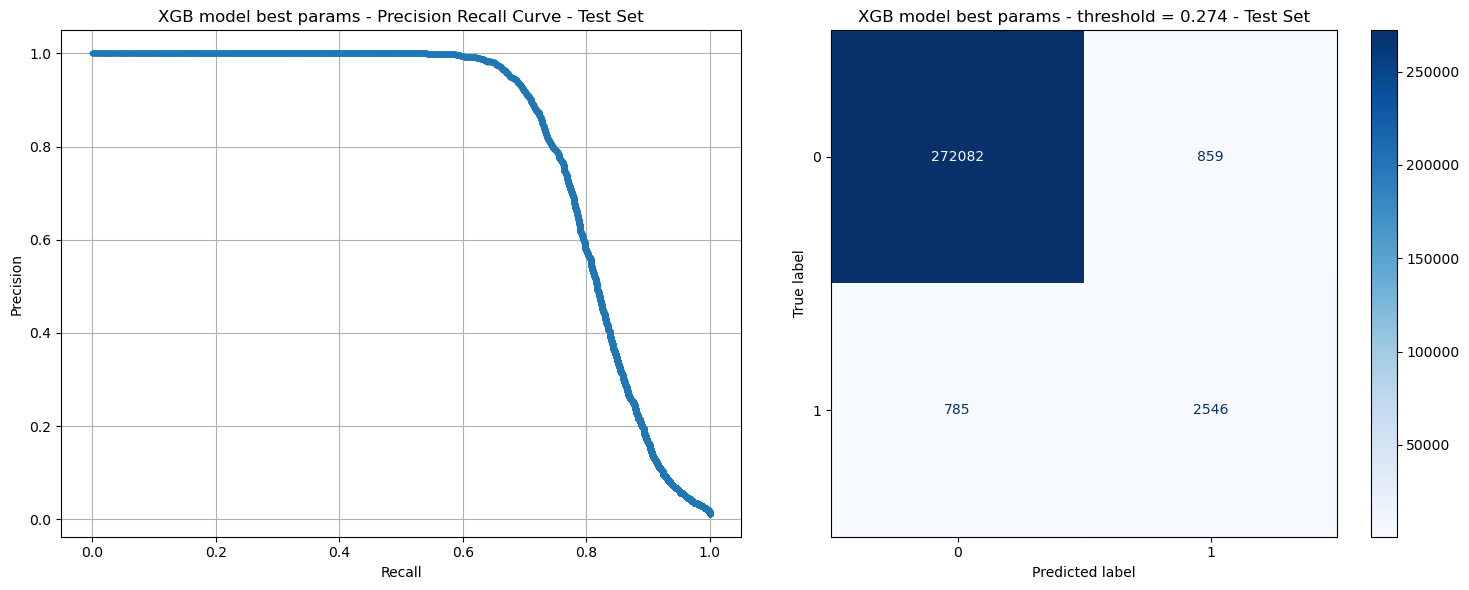

In [81]:
# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, best_params_y_proba)

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, best_params_y_pred_best_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

# Plot Precision Recall Curve and Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Precision-Recall Curve
ax[0].plot(recall, precision, marker='.')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('XGB model best params - Precision Recall Curve - Test Set')
ax[0].grid()

# Plot Confusion Matrix
disp.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=True)
ax[1].set_title(f'XGB model best params - threshold = {best_params_optimal_threshold:.3f} - Test Set')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

Similar curve to the baseline model but the performance has been improved. Tuning the model further to increase recall by some amount could be desireable in a
future iteration. 

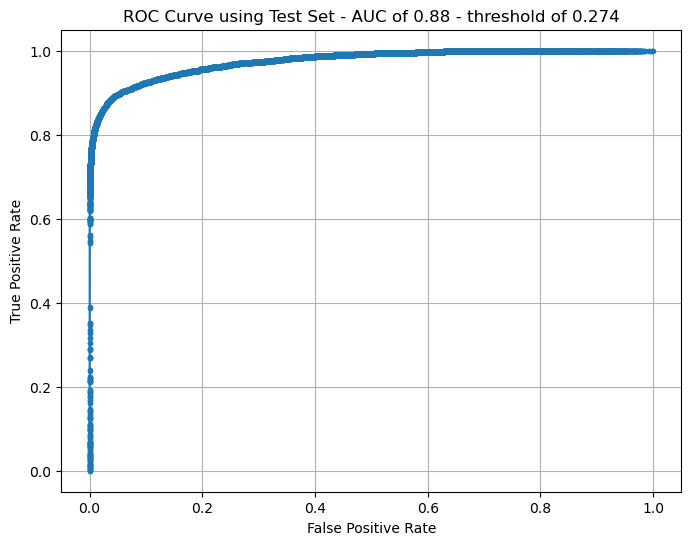

In [82]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, best_params_y_proba)

# Compute AUC score
auc_score = roc_auc_score(y_test, best_params_y_pred_best_threshold)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve using Test Set - AUC of {auc_score:.2f} - threshold of {best_params_optimal_threshold:.3f}')
plt.grid()
plt.show()

Also a good curve. The model is doing reasonably well in terms of distinguishing between the classes.

## <a id='toc10_3_'></a>[Hyperparameter Tuning Results](#toc0_)

In [83]:
# Evaluate final performance
final_f2 = fbeta_score(y_test, best_params_y_pred_best_threshold, beta=2)
print(f"Optimal Threshold for tuned model: {best_params_optimal_threshold}, Final F2 Score: {final_f2}")

XGB_model_best_params_results = create_classifier_scores_object(y_test, best_params_y_pred_best_threshold, print_results = True)

auc = roc_auc_score(y_test, best_params_y_pred_best_threshold)
print(f'AUC: {auc}')

Optimal Threshold for tuned model: 0.2744584381580353, Final F2 Score: 0.760954031920617
Accuracy: 0.9940493426767824
Precision: 0.7477239353891336
Recall: 0.764335034524167
F1: 0.755938242280285
F05: 0.7509881422924902
F2: 0.760954031920617
Matthews Corr Coef: 0.7529731287206687
AUC: 0.8805939171067386


In [84]:
final_model_scores_models = [XGBoost_test_set_results,XGB_model_best_params_results]
final_model_scores_test_set_results = prep_classifer_score_obj_for_visuals(final_model_scores_models,round_level = 5,units = None)

In [85]:
results_models_index_names = ['Baseline XGB model - Threshold 0.5',f'Tuned XGB model - Threshold {best_params_optimal_threshold:.3f}']

final_model_scores = pd.DataFrame(final_model_scores_test_set_results, index = results_models_index_names) 

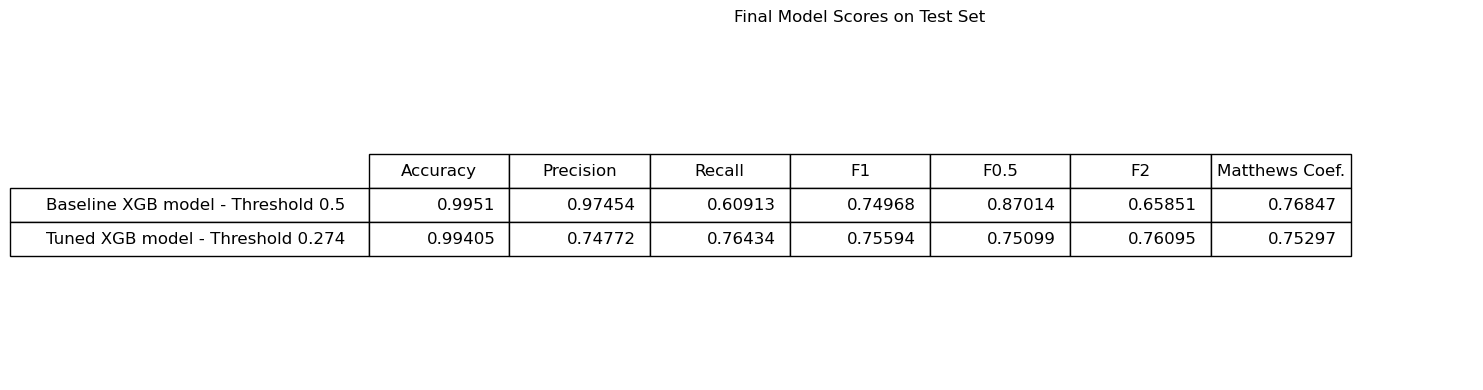

In [86]:
# Plot a table
fig, ax = plt.subplots(figsize=(15, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=final_model_scores.values, colLabels=final_model_scores.columns, rowLabels=final_model_scores.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Final Model Scores on Test Set')

plt.tight_layout()
 
plt.show()

Accuracy remains very high for both models due to the class imbalance. The tuned model shows more balance between precison and recall and has a much better 
F2 score, which makes sense given that this was what the model was optimized for. 

# <a id='toc11_'></a>[Train model on all data](#toc0_)

In [87]:
#X_leipzig_with_new_features = leipzig_full_data_with_engineered_features.drop(columns = ['Class'])
#y_leipzig_with_new_features = leipzig_full_data_with_engineered_features['Class']

XGB_model_best_params_final = xgb.XGBClassifier(
            n_estimators = best_params[0],
            max_depth = best_params[1],
            scale_pos_weight = best_params[2],
            eta = best_params[3],
            gamma = best_params[4],
            min_child_weight = best_params[5],
            subsample = best_params[6],
            reg_lambda = best_params[7],
            alpha = best_params[8],
            objective='binary:logistic',  
            eval_metric='logloss',        
            use_label_encoder=False,       # Avoid deprecation warnings
            random_state=42)


XGB_model_best_params_final.fit(X_leipzig_with_new_features, y_leipzig_with_new_features)


XGBClassifier(alpha=10.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=10.0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1500,
              n_jobs=None, ...)

# <a id='toc12_'></a>[Save Model](#toc0_)

In [88]:
#XGB_model_best_params_final.save_model('../models/XGB/XGB_model_best_params_final.json')

import pickle

# Save the model to a file
with open('../models/XGB/XGB_model_best_params_final.pkl', 'wb') as file:
    pickle.dump(XGB_model_best_params_final, file)

# <a id='toc13_'></a>[Test saved model on Greifswald medical center](#toc0_)

## <a id='toc13_1_'></a>[Prep Greifswald data set as unseen data](#toc0_)

In [89]:
greifswald_full_data_with_engineered_features.head()

,Age,Time,HGB,MCV,PLT,RBC,WBC,Class,test_sequence,interval_from_last_test,...,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2,binary_feature_sex_W
0,25,0.0,7.0,80.5,264.0,4.2,8.40,0,1,0.0,...,4.2,0.0,4.2,4.2,8.40,8.40,0.0,8.40,8.40,True
1,75,0.0,8.4,87.9,260.0,4.8,8.47,0,1,0.0,...,4.8,0.0,4.8,4.8,8.47,8.47,0.0,8.47,8.47,False
2,69,0.0,7.8,91.7,179.0,4.2,9.15,0,1,0.0,...,4.2,0.0,4.2,4.2,9.15,9.15,0.0,9.15,9.15,False
3,88,0.0,8.2,88.2,234.0,4.3,7.59,0,1,0.0,...,4.3,0.0,4.3,4.3,7.59,7.59,0.0,7.59,7.59,True
4,75,0.0,8.1,96.7,197.0,4.2,7.85,0,1,0.0,...,4.2,0.0,4.2,4.2,7.85,7.85,0.0,7.85,7.85,False


In [90]:
greifswald_full_data_with_engineered_features_X_test = greifswald_full_data_with_engineered_features.drop(columns = ['Class'])
greifswald_full_data_with_engineered_features_y_test = greifswald_full_data_with_engineered_features['Class']

## <a id='toc13_2_'></a>[Load Model](#toc0_)

In [91]:
# Load the model from a file
with open('../models/XGB/XGB_model_best_params_final.pkl', 'rb') as file:
    best_model = pickle.load(file)

In [92]:
#check params
best_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': 0.0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 11,
 'max_leaves': None,
 'min_child_weight': 10.0,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': 1.332913648523872,
 'sampling_method': None,
 'scale_pos_weight': 50,
 'subsample': 0.9249283573691198,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1,
 'alpha': 10.0,
 'use_la

## <a id='toc13_3_'></a>[Model Predictions and results on Greifswald data](#toc0_)

In [93]:
#predict
y_pred_greifswald = best_model.predict(greifswald_full_data_with_engineered_features_X_test)
y_pred_greifswald_proba = best_model.predict_proba(greifswald_full_data_with_engineered_features_X_test)[:, 1]  # Get probabilities for the positive class


In [94]:
#Find optimal Threshold for F2
y_pred_greifswald_best_threshold = (y_pred_greifswald_proba >= best_params_optimal_threshold).astype(int)

In [95]:
greifswald_results = create_classifier_scores_object(greifswald_full_data_with_engineered_features_y_test, y_pred_greifswald_best_threshold, print_results = True)
auc = roc_auc_score(greifswald_full_data_with_engineered_features_y_test, y_pred_greifswald_best_threshold)
print(f'AUC: {auc}')

Accuracy: 0.9871141374689838
Precision: 0.1724813798510388
Recall: 0.11071967790639155
F1: 0.13486590038314175
F05: 0.15516998166172946
F2: 0.11926058437686345
Matthews Corr Coef: 0.13190665830048914
AUC: 0.5529283883527623


In [96]:
# Compare the results to the baseline and test sets from above
results_models_incl_greifswald = [XGBoost_test_set_results,XGB_model_best_params_results, greifswald_results]

test_set_results_incl_greifswald = prep_classifer_score_obj_for_visuals(results_models_incl_greifswald,round_level = 5,units = None)

In [97]:
test_set_results_incl_greifswald

{'Accuracy': [0.9951, 0.99405, 0.98711],
 'Precision': [0.97454, 0.74772, 0.17248],
 'Recall': [0.60913, 0.76434, 0.11072],
 'F1': [0.74968, 0.75594, 0.13487],
 'F0.5': [0.87014, 0.75099, 0.15517],
 'F2': [0.65851, 0.76095, 0.11926],
 'Matthews Coef.': [0.76847, 0.75297, 0.13191]}

In [98]:
results_comparison_index_names_incl_greifswald = ['Baseline XGB  Threshold 0.5',
                                                  (f'Tuned XGB model Threshold {best_params_optimal_threshold:.3f}'),
                                                  (f'Tuned XGB model on Griefswald data - Threshold {best_params_optimal_threshold:.3f}')]

results_comparison_df_incl_greifswald = pd.DataFrame(test_set_results_incl_greifswald, index = results_comparison_index_names_incl_greifswald) 

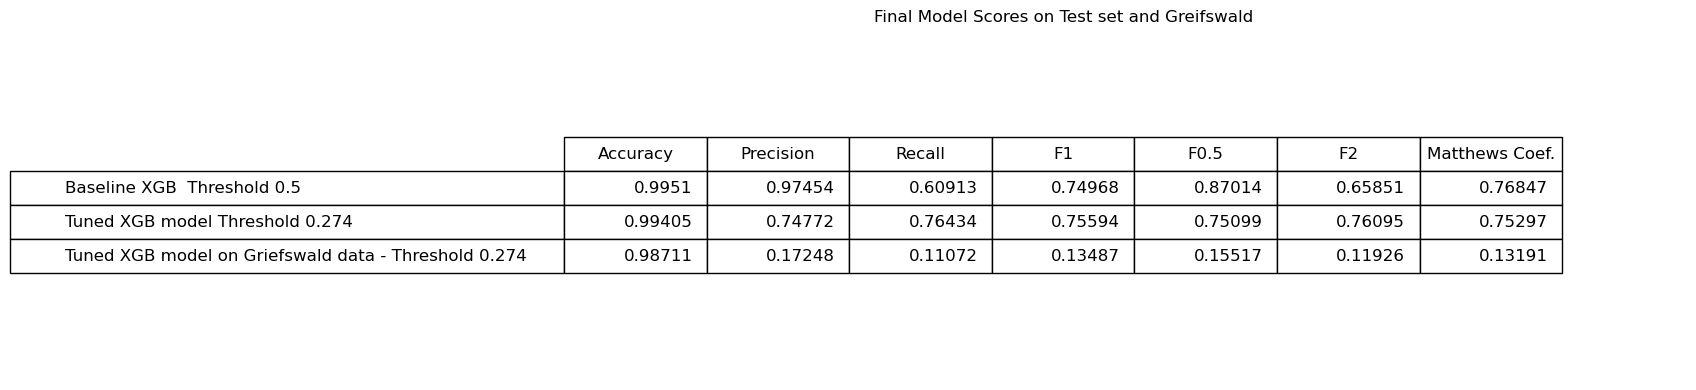

In [99]:
# Plot a table
fig, ax = plt.subplots(figsize=(17, 4))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_comparison_df_incl_greifswald.values, colLabels=results_comparison_df_incl_greifswald.columns, rowLabels=results_comparison_df_incl_greifswald.index, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.8, 1.8)  # Scale width and height; adjust the second value to change vertical padding

plt.title('Final Model Scores on Test set and Greifswald')

plt.tight_layout()
 
plt.show()


The model trained on the Leipzig data does not generalize well to the data from Greifswald medical center, which is no great suprise. It looks like the idea that each medical center should be treated separately has some merit. 

# <a id='toc14_'></a>[Model Interpretation with SHAP](#toc0_)

The below is the model trained on on the Leipzig training data. The SHAP values reflect performance on the Leipzig test set

## <a id='toc14_1_'></a>[Global Summary](#toc0_)

[08:21:53] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_d6q0e1lomi/croot/xgboost-split_1713972719224/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


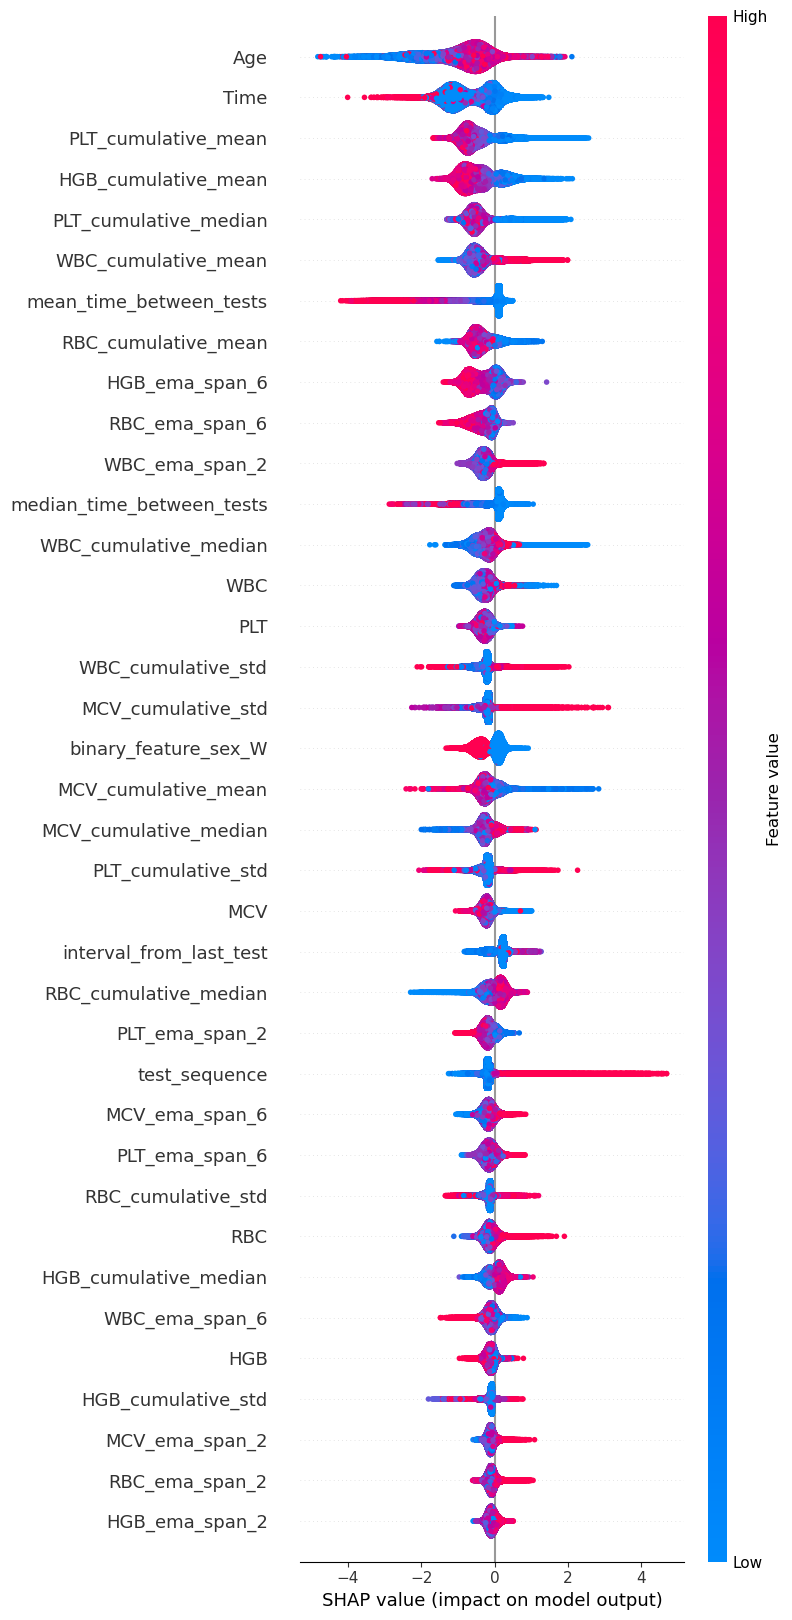

In [101]:
# Create a TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(XGB_model_best_params)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values for a single prediction (first sample)
# Create a beeswarm plot
shap.summary_plot(shap_values,X_test, max_display=len(X_test.columns))

#order by level of importance

Age  and time have the biggest impact here, followed by several time dependent features that were created in the feature engineering notebook to capture the some part of the time series aspect of the data. 

Age is not a big surprise. The SHAP value seems to be generally indicating that having a lower age value (i.e. being younger) pushes a patient closer to the negative class. 

Time being the second most impactful factor is more interesting. The time value is just a value in seconds indicating how long has passed since the first blood test for that patient. Higher values are indicating a push toward the negative class, while lower values are showing less impact. 

The next three four features in terms of importance are all cumulative means or medians for PLT, HGB and WBC values. This is interesting because the actual values for these blood tests are not as impactful as the time series features that were derived from them. This points to the change in the values over time being a better indicator than the values by themselves. 

PLT and HGB values here have a positive impact at lower values. Lower PLT counts in particular can indicate an infection, so this makes sense. 
Higher White Blood Cell counts indicate an infection as well, the impact of higher cumulative mean values in SHAP matches this. Showing a higher mean associated with a positive impact and a push towards a positive classification. 

For all of the five actual blood test values in the model, the impact is small. 
HGB may be the best example. The HGB_cumulative_mean feature is 4th in terms of impact, but the actual value of HGB in a given test is 33rd. 

The other interesting thing to note, not in terms of impact, but in terms of the clear separation of the values is the Sex feature. This was made into a binary, where a value of 1 indicates female and a value of 0 indicates make. The SHAP value shows that a low value (ie. being male) has an almost universally positive impact, which being female has a negative impact. Most of the features are muddled in some way, but this one is stark.

The time series component seems to be the salient factor here. I was not expecting that. I'll explore it further below.


## <a id='toc14_2_'></a>[Selected Features](#toc0_)

I'll plot the blood test features along with their most impactful time based equivalent below. 
I'll also plot the Age and Time features, as these were the most impactful. 

In [138]:
#define a funtion to make the plotting less cumbersome. 

def plt_shap_value_pairs(feature_1, feature_2, interaction_index = None, wspace = 0.5):
    '''
    This function takes two features and creates side by side plots of their shap values for compaison.

    Parameters:
    feature_1 - A string, corresponding to the name of a feature
    feature_2 - A string, corresponding to the name of a feature
    interaction_index - Optional, A string, corresponding to the name of a feature to be used as the interaction index
    wspace - a float, controls the 

    '''
    # Create a figure with two subplots (side by side)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Plot the first SHAP dependence plot for feature1 on the first axis
    shap.dependence_plot(feature_1, shap_values, X_test, interaction_index=interaction_index,ax=axs[0], show=False)
    axs[0].set_title(f'{feature_1}')
    axs[0].set_ylabel('SHAP Values')  # Custom label for y-axis of first plot
    axs[0].axhline(y=0, color='Tab:blue', linestyle='--')

    # Plot the second SHAP dependence plot for feature2 on the second axis
    shap.dependence_plot(feature_2, shap_values, X_test, interaction_index=interaction_index, ax=axs[1], show=False)
    axs[1].set_title(f'{feature_2}')
    axs[1].set_ylabel('SHAP Values')  # Custom label for y-axis of second plot
    axs[1].axhline(y=0, color='Tab:blue', linestyle='--')

    # Adjust layout to prevent overlap

    plt.subplots_adjust(wspace=wspace)  # Increase space between the subplots
    plt.tight_layout()
    plt.show()

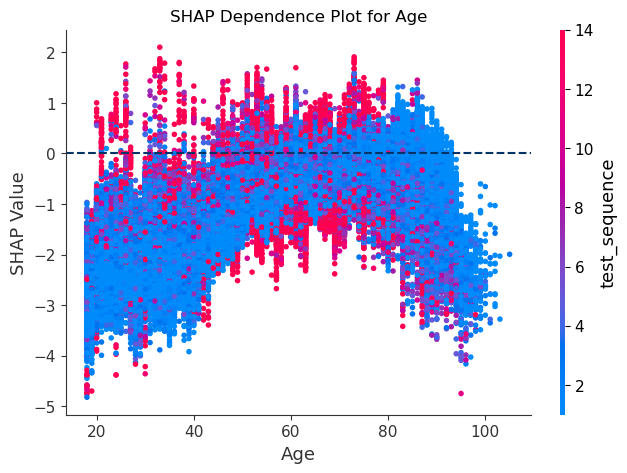

In [151]:
# Generate the SHAP dependence plot
shap.dependence_plot('Age', shap_values, X_test, interaction_index='test_sequence', show=False)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line

# Add a title to the plot
ax.set_title('SHAP Dependence Plot for Age')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Age')
ax.set_ylabel('SHAP Value')

# Show the plot
plt.show()

The SHAP plot for age here is a little confusing. Age is the most impactful factor according the global plot, but there are examples at every age of the 
age factor having a negative impact on the model. This is less pronounced in the lower ages to be sure, but it's also much less pronounced in the upper
ages. But age as a whole feature seems to be having an overall negative impact on the model generally. That is, at any age in the data here, there is a case to be made that 
the age value is more likely to reduce the chances of a positive (Sepsis) classification for a blood test. The SHAP plot here is pretty striaght forward, but in the real world this doesn't make a lot of sense. 

The interaction index here is test_sequence, but it doesn't seem to add a whole lot of clarity in this case. There are examples of high and low test sequences at every age with negative and positive impact. 

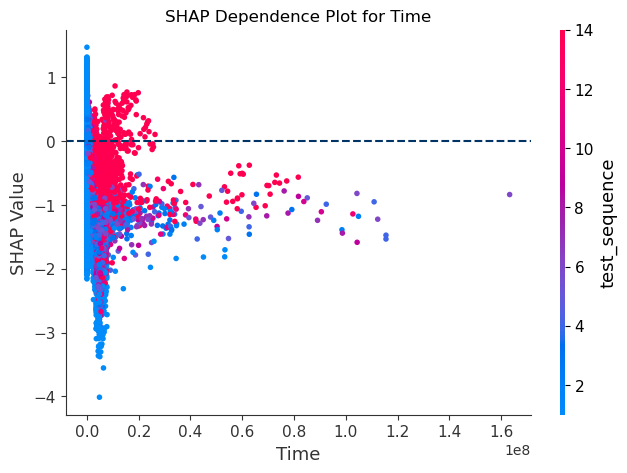

In [150]:
# Generate the SHAP dependence plot
shap.dependence_plot('Time', shap_values, X_test, interaction_index='test_sequence', show=False)

# Get the current axes
ax = plt.gca()

# Add a horizontal line at y=0
ax.axhline(y=0, color='#003366', linestyle='--')  # Dark blue line

# Add a title to the plot
ax.set_title('SHAP Dependence Plot for Time')

# Optionally, set labels for the x and y axes
ax.set_xlabel('Time')
ax.set_ylabel('SHAP Value')

# Show the plot
plt.show()


Time being the second most impactful factor is more interesting. The time value is just a value in seconds indicating how long has passed since the first blood test for that patient. 
Higher values are indicating a push toward the negative class, while lower values still seem to be net negative but also push the model towards a positive class in some cases. 
Larger time values in general seem to have a negative impact. 

The data points with higher test sequences are clustered in the upper part of the plot, indicating that multiple tests, close together might have the most positive impact on
the model. Even then, the impact is not huge.

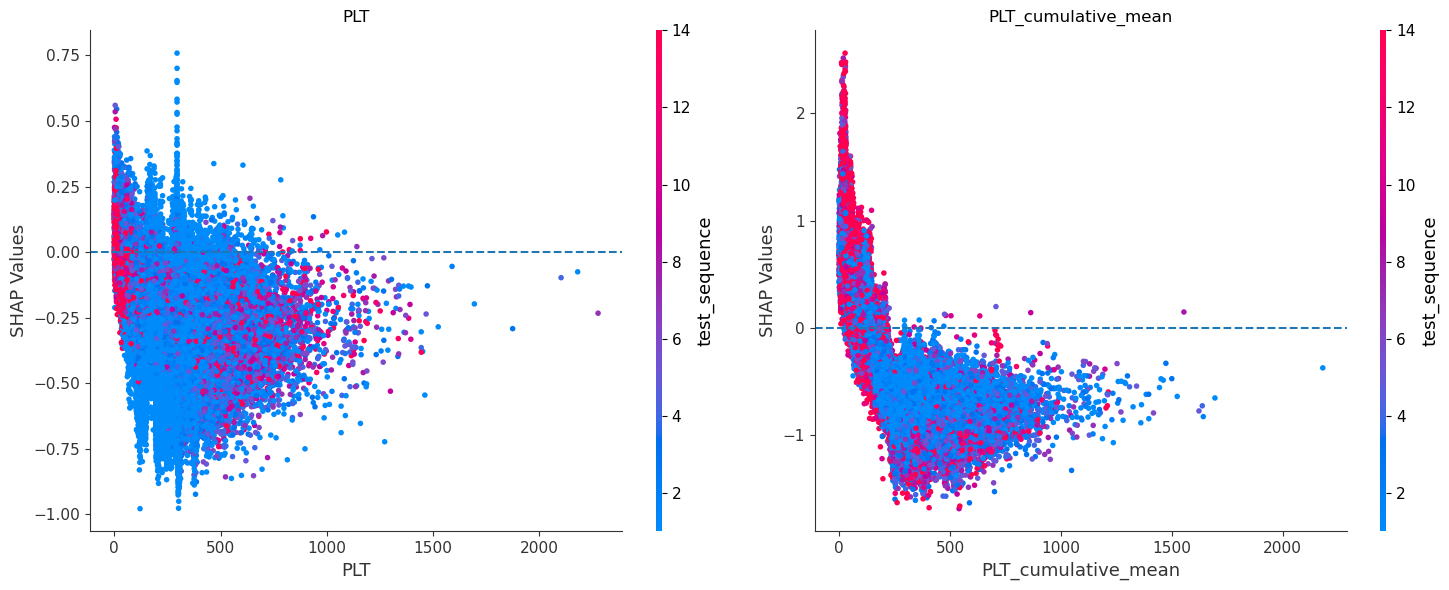

In [146]:
plt_shap_value_pairs('PLT', 'PLT_cumulative_mean', interaction_index = "test_sequence")   #"Age")

The actual blood test data here is on the left, and the cumulative mean derived from that data is on the right. The cumulative mean is the cumulative mean value of a given test and all prior tests for that patient. For patients with only one test, the cumulative mean is just the value of the single test. 

A low platelet count can be associated with infection, so it would be expected that a lower count would have a positive impact on the model. That's sort of visible in the left plot, 
but it's dramatic in the right plot that captures more of the time dependent value over multiple tests.  

I've made the interaction index on this plot test_sequence in instead of age to better illustrate. There does seem to be a cluster of higher test sequence values in the lower PLT 
value spike on the right. That means that there were multiple tests prior to the ones shown in the spike, all of which were either at a low PLT value, or which moved towards that lower value over several tests. 

This could, of course, just reflect patients who seem sick getting more blood tests as they become sicker. Even so, it seems here like a good illustration of how a changing value over several tests might affect the model. 

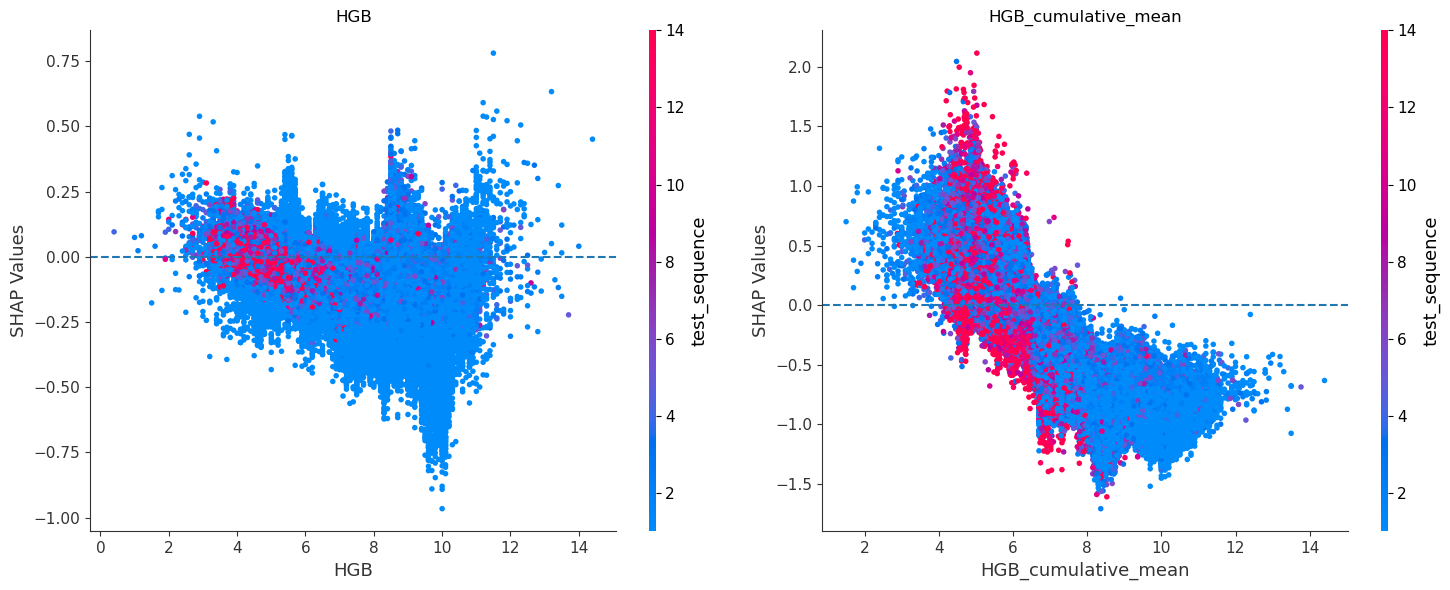

In [147]:
plt_shap_value_pairs('HGB', 'HGB_cumulative_mean', interaction_index = "test_sequence")

A similar pattern here. The feature on the right includes a time component and displays a clearer pattern than the same blood test value on the right. 

In this case, tests with a higher sequnece are clustered between about 4 and about 8 in terms of HGB value. Values on the lower end of that tend to have a positive impact on the model if the test showing that lower value is coming at the end of a series of tests. 

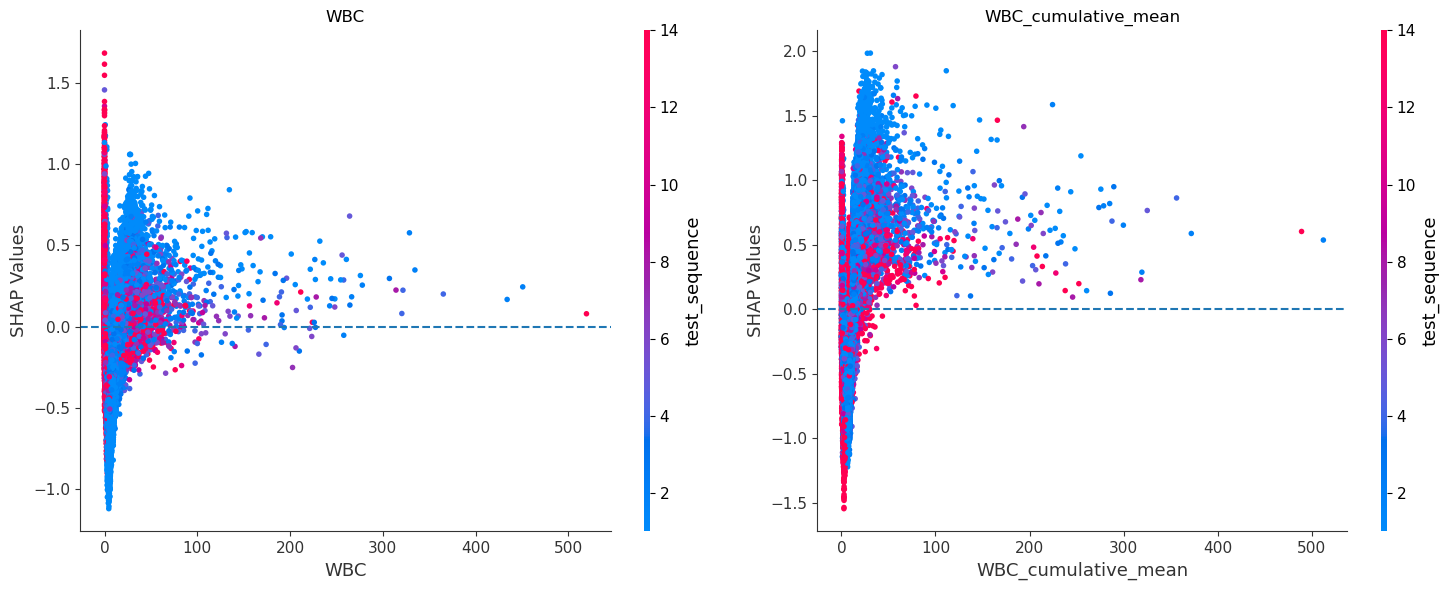

In [148]:
plt_shap_value_pairs('WBC', 'WBC_cumulative_mean', interaction_index = "test_sequence")

Similar plot shapes here, but the right feature with the cumulative value has a higher total impact range.  The test sequence seems to be less relvent than in the examples above. 
Basically any WBC value over about 50 almost always has a positive impact on the model. 

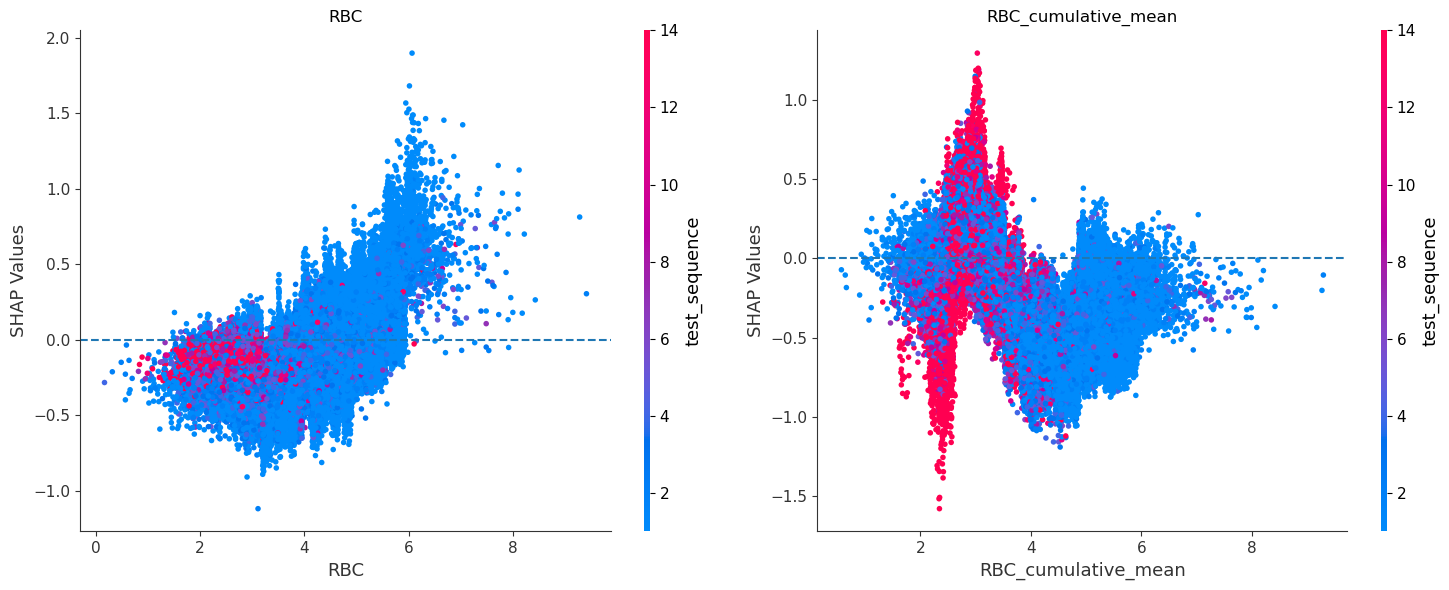

In [149]:
plt_shap_value_pairs('RBC', 'RBC_cumulative_mean', interaction_index = "test_sequence")

RBC values below about 4.5 seem to be associated with higher test sequnce values generally. The cumulative_mean distribution on the right shows two spikes with approximately equal impact on the model but in opposite directions. The model is pushed in a positve direction between cumulative RBC mean values of between approximately 3 and 4. 
Values below about 3 have a negative impact on the model when they are the found at the end of multiple tests.

Interestingly, values at the higher end of the RBC scale show a positive impact when looked at as a single RBC test value, but they have a negative impact when looking at the cumulative mean. The tests with higher sequence numbers cluster in the same range of RBC values in both cases. 


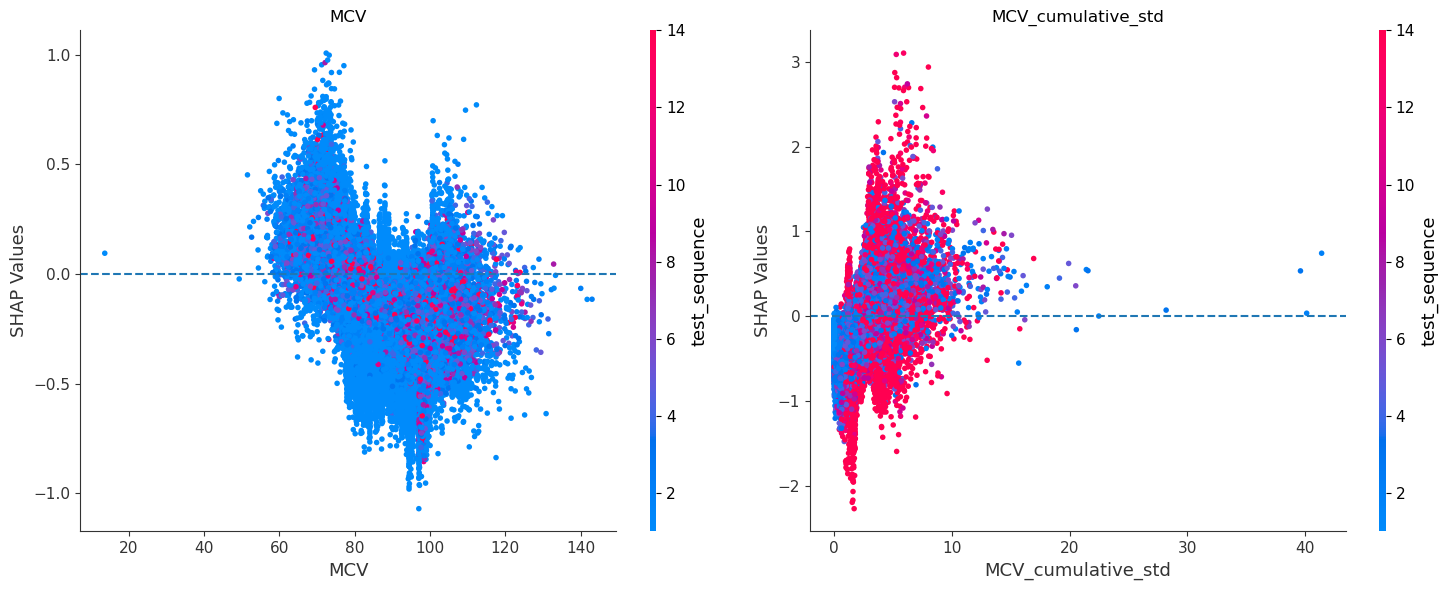

In [152]:
plt_shap_value_pairs('MCV', 'MCV_cumulative_std', interaction_index = "test_sequence")

This last blood test value was different from the others in that cumultive standard deviation was the higher impact feature, not cumulative mean as with the others. 
Again the pattern shown by the feature that includes a time component is different. In this case, as the cumulative standard deviation of the values for MCV increases over multiple tests, the impact tends to become more positive. 

# <a id='toc15_'></a>[Summary](#toc0_)

## <a id='toc15_1_'></a>[Model Exploration and Sampling Methods](#toc0_)

In this notebook I tried several modeling approaches to the full data set from the Leipzig medical center. 

The following models were looked at either using cross validation or results on the test set: 

 - XGBoost
 - Random Forest
 - Balanced Random Forest
 - SVM
 - Single Class SVM
 - Logistic Regression

The SVM models in particular required very long run times for a full cross validation, and I used the baseline results on the test set to gauge the potential of the basic model. 
Because of the large class imbalance in the data, the accuracy for all the models we very high, above 0.95 in many cases. The best baseline model in terms of precision, recall, F1, F2 and MCC performance was the XGBoost model. This matched some of the results from the preprocessing notebook, which showed that this model had a fairly good out of the box performance. Random Forest also performed well, but not quite as well. 
The other models did not perform well enough to warrant continued development. XGB was the clear choice. 

Having selected a model for further development. I briefly explored the effects of various values for the class weighting parameter for XGB. Varying the class weights resulted in significant an positive performance changes and the results were enough for me to include class weights as a parameter in the tuning process. 

Because of the large class imbalance, I next explored three treatments for the data itself as follows:

 - Under-sampling the negative class using RandomUnderSampler 
 - Over-sampling using SMOTE 
 - Over-sampling and noise reduction using SMOTEENN


I ran each of the above through an XGB baseline model  with the default sampling setting to gain a better understanding of the performance potential of the various approaches. 

All of these approaches caused the model to overfit to some degree.
Even SMOTEENN, which is meant to reduce the overfitting potential caused significant overfitting on the training set. 

## <a id='toc15_2_'></a>[Hyperparameter Tuning - Model Testing - Model Interpretation](#toc0_)

I was hopeful that parameter tuning, for example varying the number of estimators and the class weights would help alleviate some of the overfitting from the various sampling methods. To find out I tuned a model on the normal data, the resampled SMOTE data and the resample SMOTEENN data. 
All three data sets were run through an optimization process using skopt's gp.minimize. 
The metric that was minimized was the F2 score, which I negated in the objective functions to ensure that it would be maximized by the optimization process. 
All objective functions were run through 80 iterations of search in the parameter space . 

At the end of the tuning I compared the results and the normal data provided the best performance. I selected the model with the best parameters for the normal data and determined the best threshold for predictions to maximize performance. To avoid using the test set, the best threshold was determined by running 5 fold-cross validation, determining the best threshold for each fold and then averaging the results. 

The model with the best parameters and the best threshold was applied to the test set and the results were compared the baseline model created in the first section of the notebook. 

The tuning process resulted in a substantial improvement over the baseline performance, and in a decent model performance on the test set.

Because no over or under sampling was used, the class imbalance in the train and test sets was as follows.

 - Class percentages:
- 0    98.794375
- 1     1.205625 

I trained a new version of the model with the best params and optimal threshold on all the data and saved it for later use. 


Finally, the saved model was then used to predict on the data from the Griefswald medical center. It did not generalize well to this data, which is in line with the approach throughout this project of treating the two medical centers contained in the data as separate entities. The centers are not near each other, and EDA showed that there are some significant differences in the patient data from each. Given this, it was not a huge suprise that a model that performed well on one center would do poorly on the other. 
Finally, 

I used SHAP to interpret the model. The SHAP analysis was run on the model trained on the Leipzig data only, not the one used to predict on Griefswald. 
The results of the SHAP analysis were surprising, and point to avenues for further work on this problem of sepsis detection. More detail on that can be found in the SHAP analysis section above. 

## <a id='toc15_3_'></a>[Conclusions and further work](#toc0_)

In terms of next steps, the following appear to be promising avenues for further work:

1. Develop a similar model for the Greifswald data and see if it generalizes to the Leipzig data set. Basically the inverse of this notebook. This will provide added insight into whether the modeling approach used here can be applied to other data sets from other centers. It will also provide another data point in terms of how well a model from one medical center might be expected to apply to others. 



2. Try a similar modeling approach with data where the blood tests in the positive class have been selected based on proximity to ICU admission. The initial results from this in preprocessing were not promising, but the modeling approach developed here, combined with some additional tweaking of over and under sampling may still lead to good results. 



3. Try additional modeling approaches, such as deep learning or transformers, so see if the relationships can be better captured by those methods than by the boosted tree methods used in this project and in the original paper. 



4. Find additional data or additional features that better capture the time dependent component. The SHAP analysis seemed to indicate that the blood test data in and of itself is not the most important factor in driving prediction, instead, the time dependent features seemed to have the greatest effect. This suggests that Sepsis detection may be best approached as a time series problem. The data set here contains some time series information, which was the basis for the time dependent features, but most of the blood test data in the data set does not have this component. Framing the problem explicitly as a time series problem may provide a good framework for additional data acquisition and modeling efforts. 



5. Determine what other factors, for example BPM are used in the current diagnosis of Sepsis and incorporate them into additional data gathering efforts. 